# <font color='purple'>Preprocessing QC statistics </font> 
## Noam, July 2023


In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
MOMAPS_HOME = '/home/labs/hornsteinlab/Collaboration/MOmaps_Sagy/MOmaps'
MOMAPS_DATA_HOME = '/home/labs/hornsteinlab/Collaboration/MOmaps'
LOGS_PATH = os.path.join(MOMAPS_DATA_HOME, "outputs/preprocessing/spd/logs/preprocessing_FUS")
PLOT_PATH = os.path.join(MOMAPS_DATA_HOME, "outputs/preprocessing/spd/logs/preprocessing_FUS/plots")
os.chdir(MOMAPS_HOME)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["image.cmap"] = "Set1"
from src.common.lib.preprocessing_utils import rescale_intensity
from src.common.lib.images_qc import *
import contextlib
import io
import matplotlib
import warnings
warnings.filterwarnings('ignore', category=pd.core.common.SettingWithCopyWarning)
from src.common.lib.qc_config_tmp import *
from src.common.lib.image_sampling_utils import *
from matplotlib.colors import LinearSegmentedColormap

In [3]:
pd.__version__

'1.3.5'

In [2]:
df = log_files_qc(LOGS_PATH)
df_dapi = df[df.marker=='DAPI']
df_target = df[df.marker!='DAPI']

reading logs of batch1_old
reading logs of batch1
reading logs of plots

Total of 9 files were read.
Before dup handeling  (476806, 22)
After duplication removal #1: (259303, 23)
After duplication removal #2: (250239, 23)


In [3]:
# choose batches
# batches = [f'batch{i}' for i in range(2,6)]
batches = ['batch1']
batches

['batch1']

### Raw Files Validation

1. How many site **tiff** files do we have in each folder?
2. Are all existing files valid? (tif, at least 2049kB, not corrupetd)

batch1
Folder structure is valid.
No bad files are found.
Total Sites:  203999


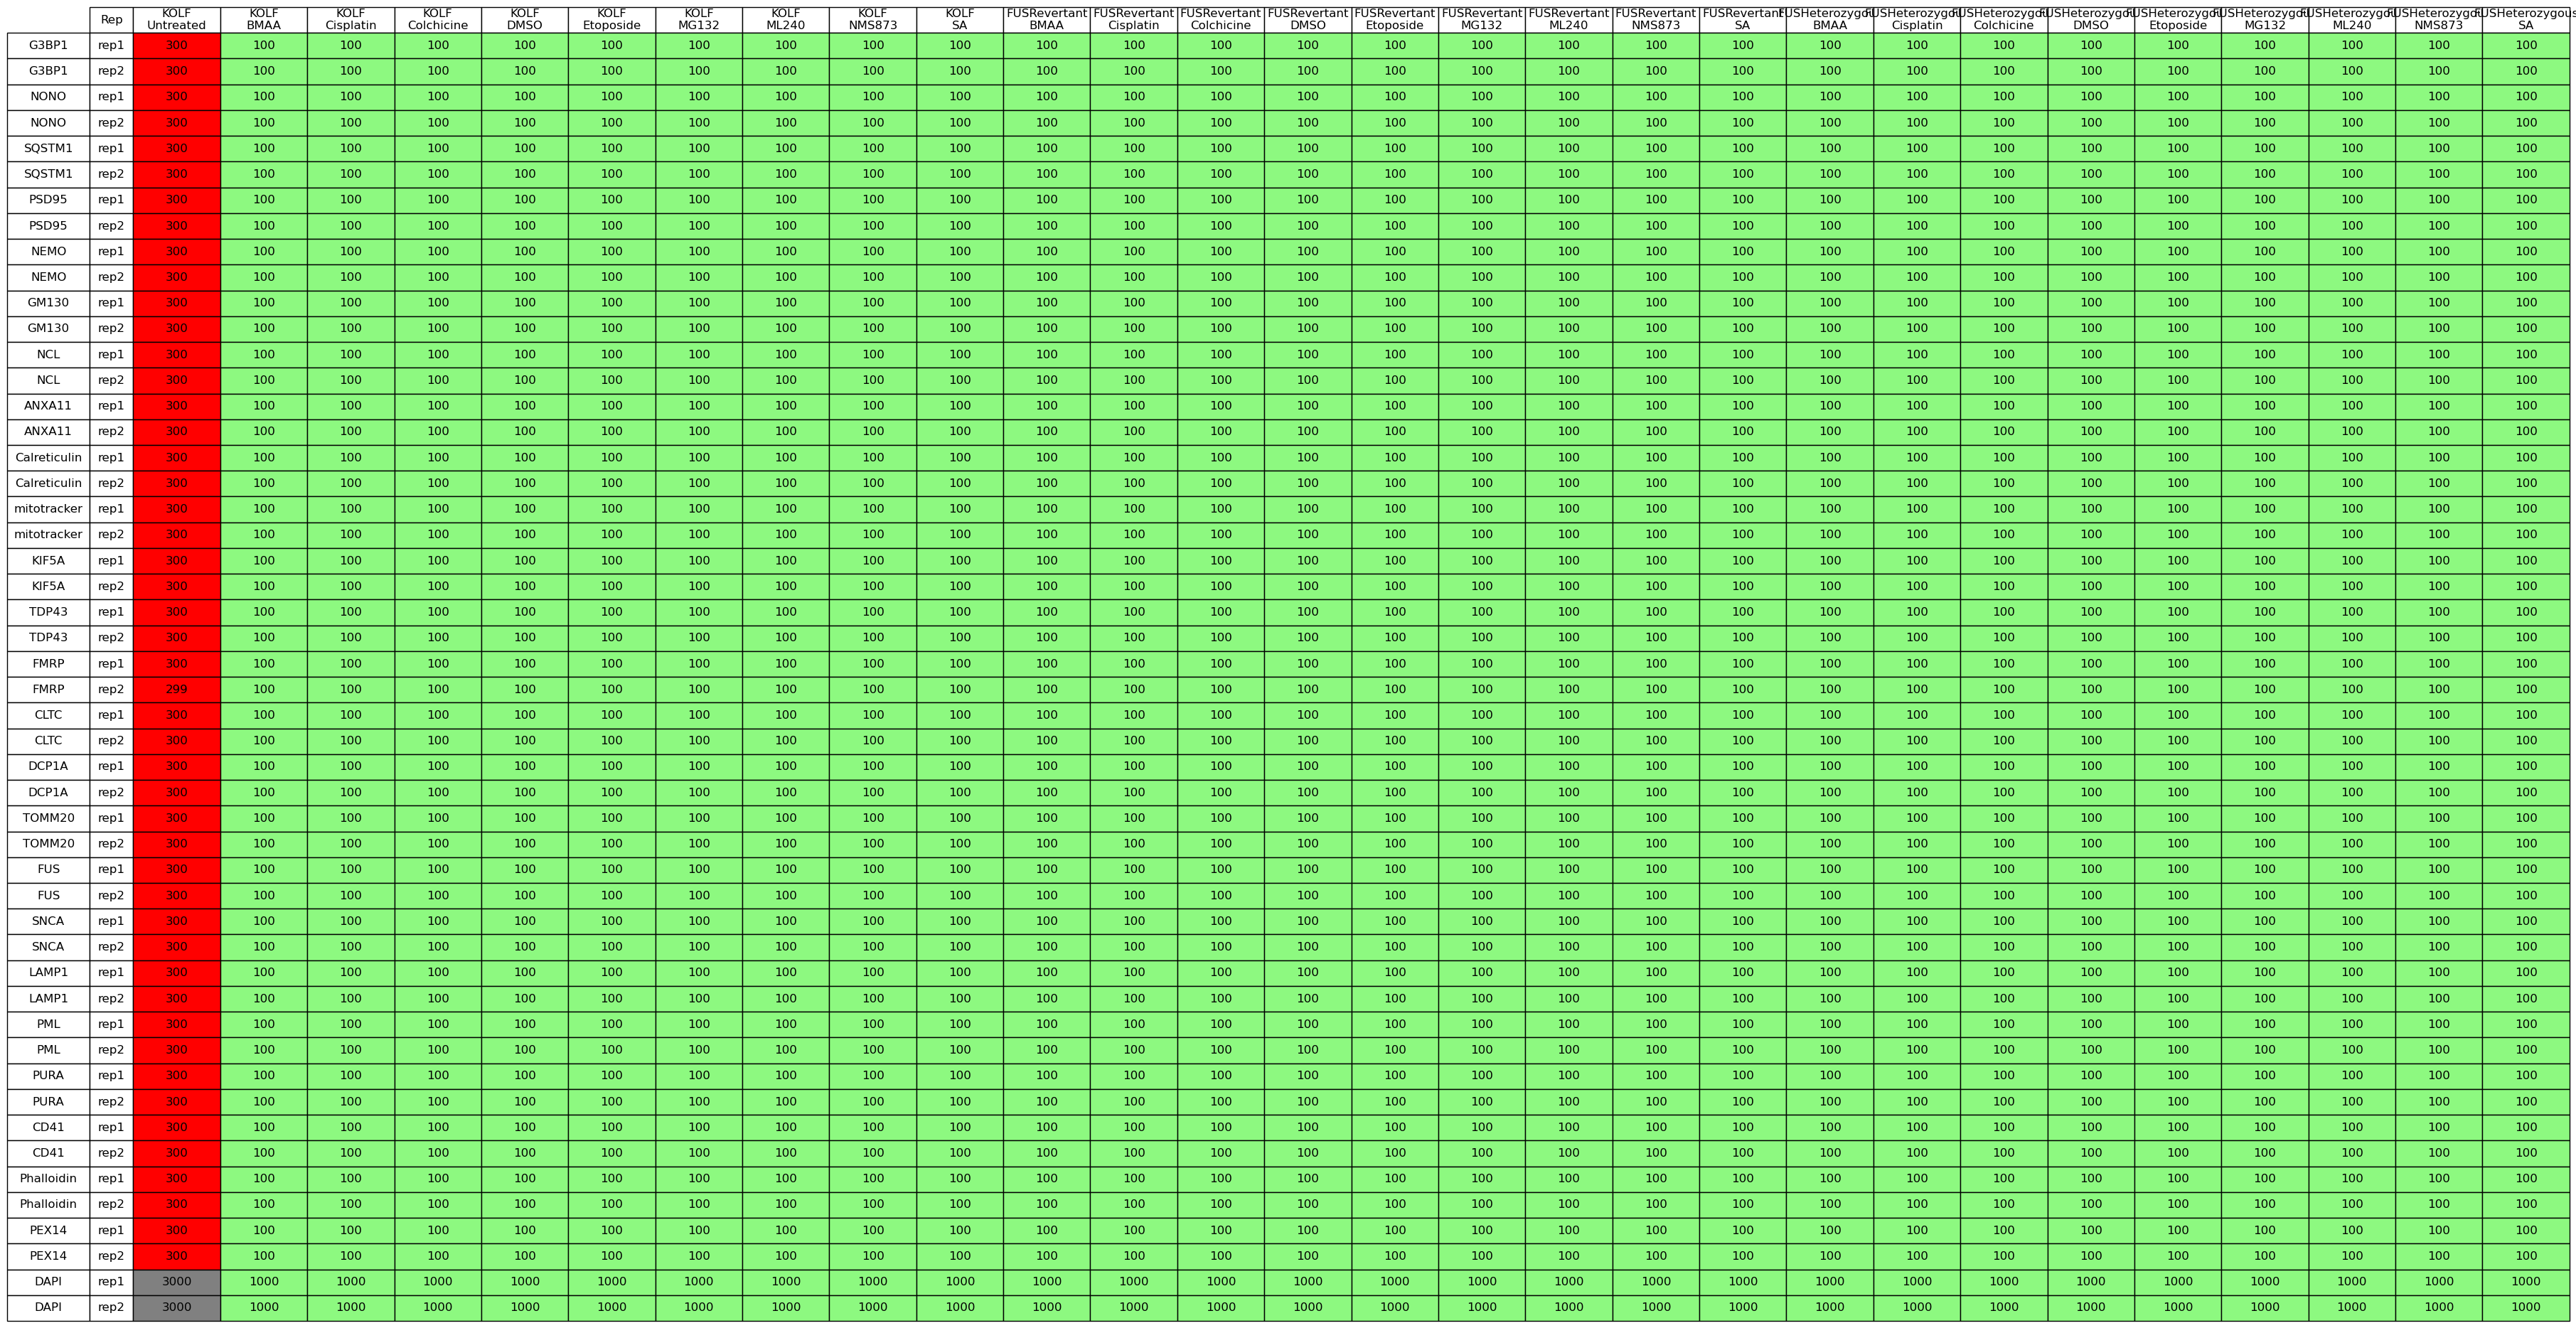

In [4]:

root_directory_raw = os.path.join(MOMAPS_DATA_HOME, 'input', 'images', 'raw', 'SpinningDisk','FUS_lines_stress_2024_sorted')

batches_raw = [batch.replace("_16bit_no_downsample","") for batch in batches]
raws = run_validate_folder_structure(root_directory_raw, False, fus_panels, fus_markers.copy(),PLOT_PATH, fus_marker_info,
                                    fus_cell_lines_to_cond, reps, fus_cell_lines_for_disp, fus_expected_dapi_raw,
                                     batches=batches_raw, fig_width=15)

### Processed Files Validation

1. How many site **npy** files do we have in each folder? -> How many sites survived the pre-processing?
2. Are all existing files valid? (at least 100kB, npy not corrupted)

batch1
Folder structure is valid.
No bad files are found.
Total Sites:  174609


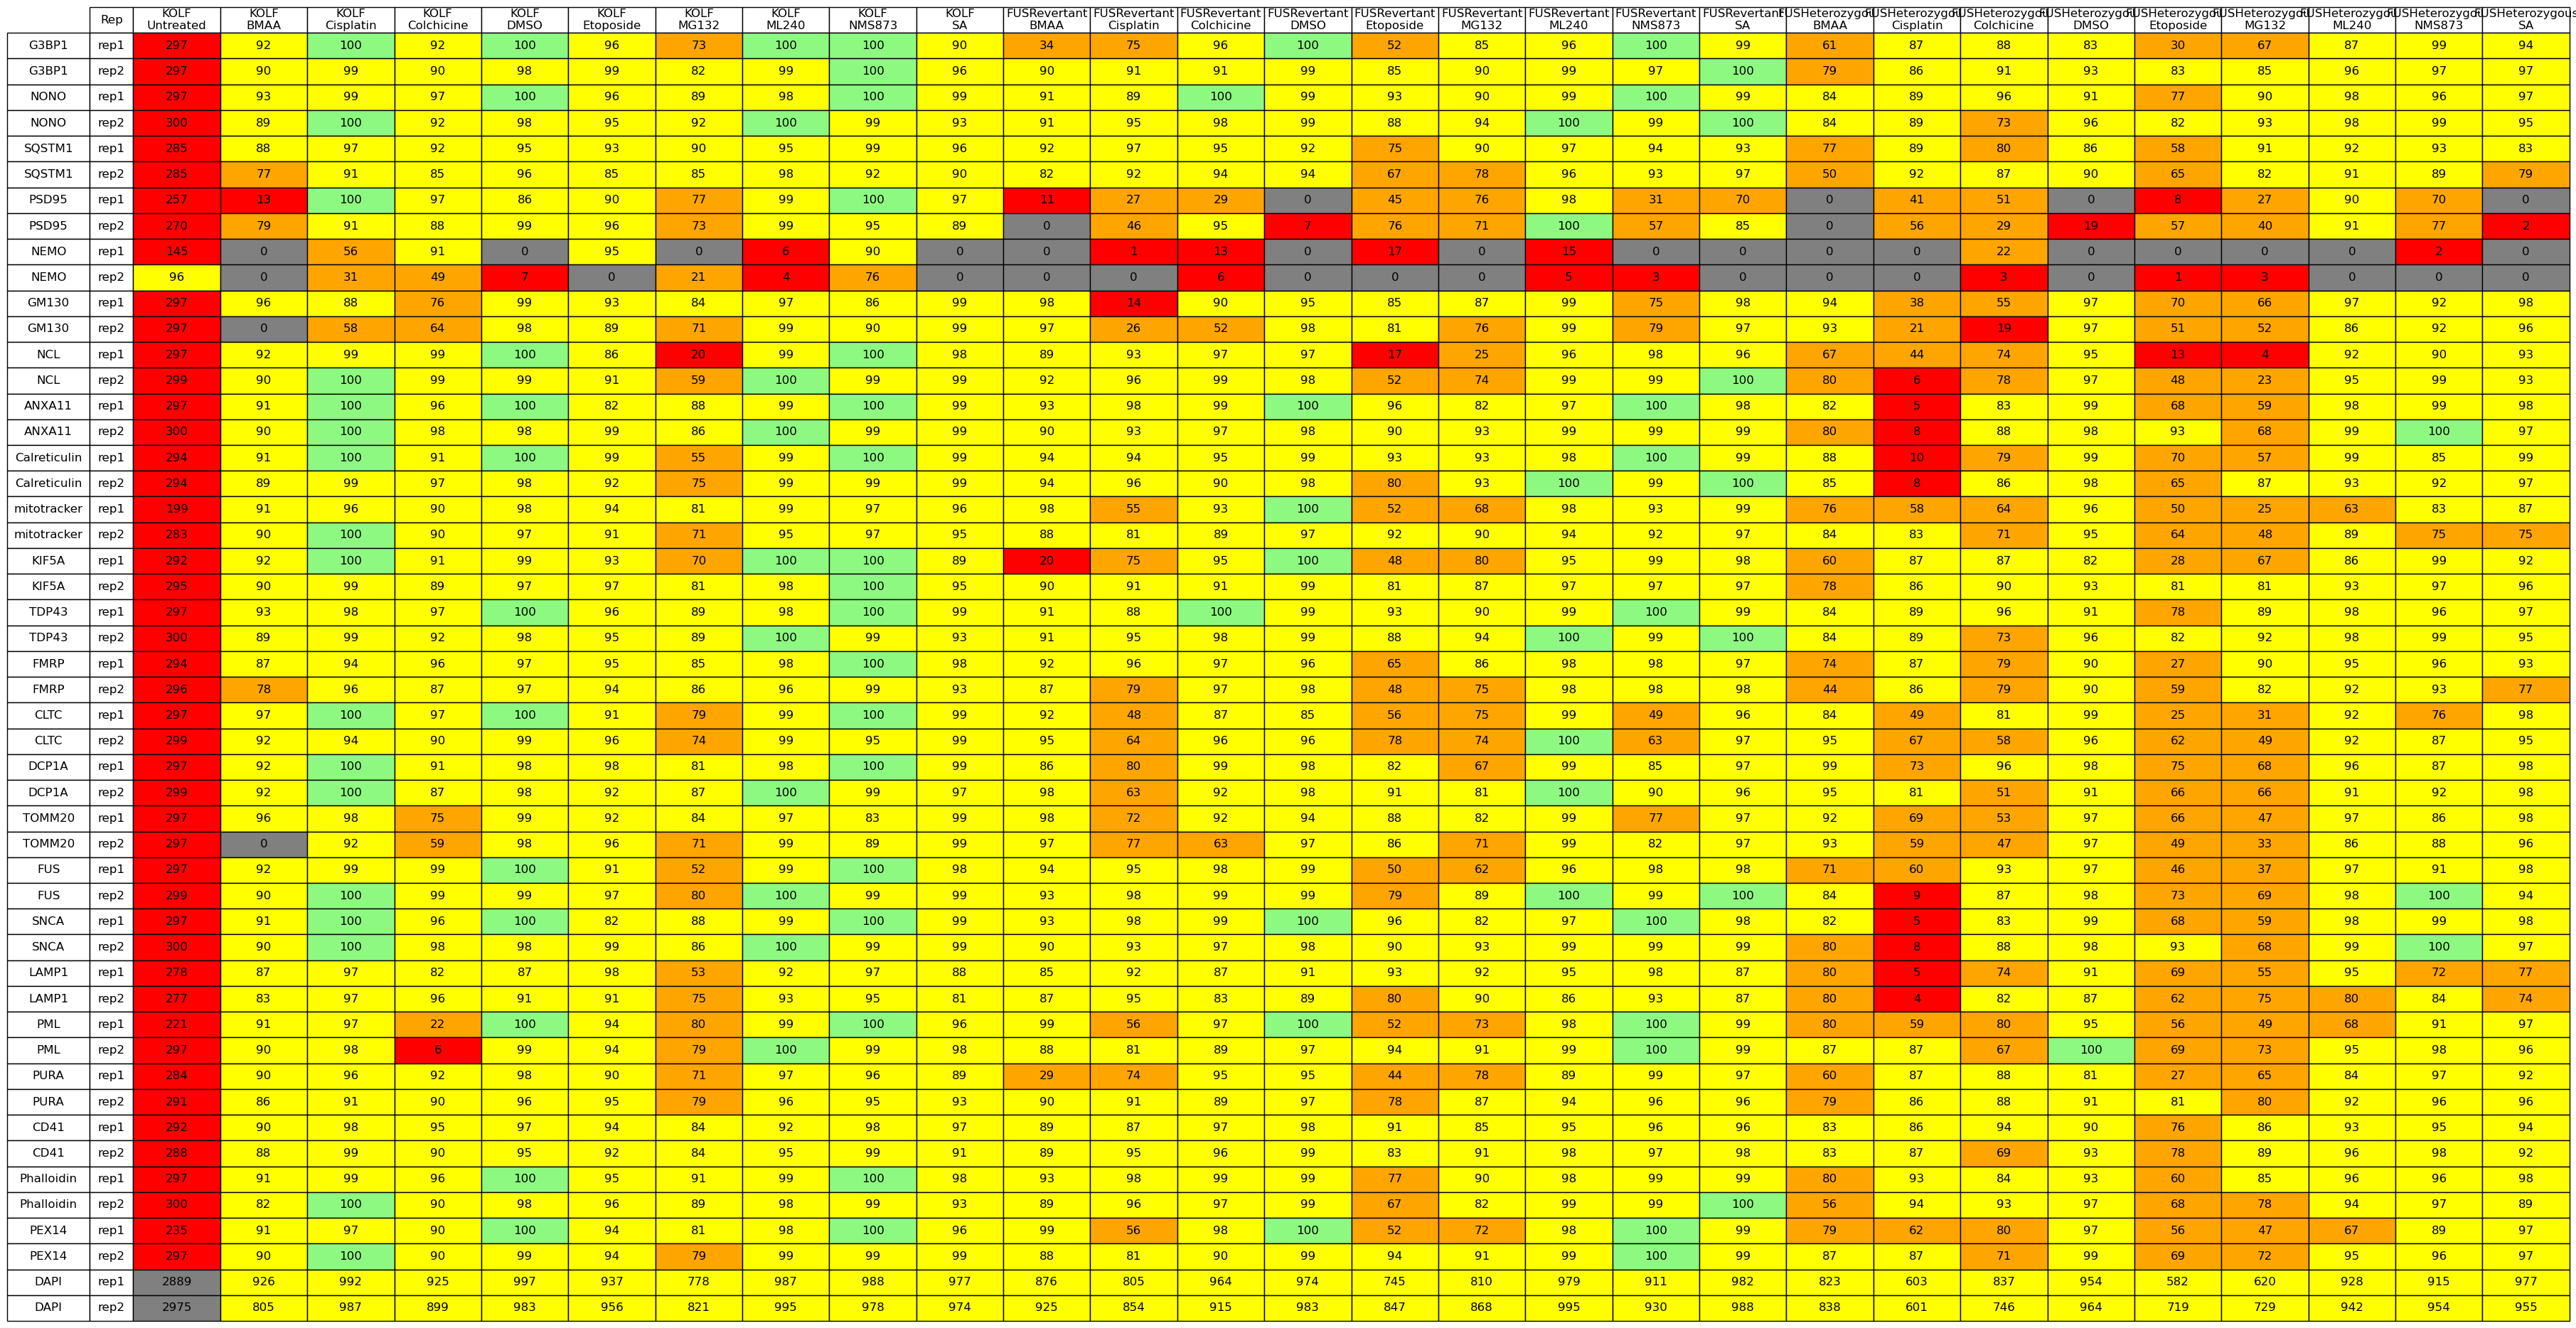

In [5]:
root_directory_proc = os.path.join(MOMAPS_DATA_HOME, 'input', 'images', 'processed', 'spd2',
                              'SpinningDisk','FUS_lines_stress_2024_sorted')
procs = run_validate_folder_structure(root_directory_proc, True, fus_panels, fus_markers,PLOT_PATH,fus_marker_info,
                                    fus_cell_lines_to_cond, reps, fus_cell_lines_for_disp, fus_expected_dapi_raw,
                                     batches=batches, fig_width=15)

### Difference between Raw and Processed

batch1


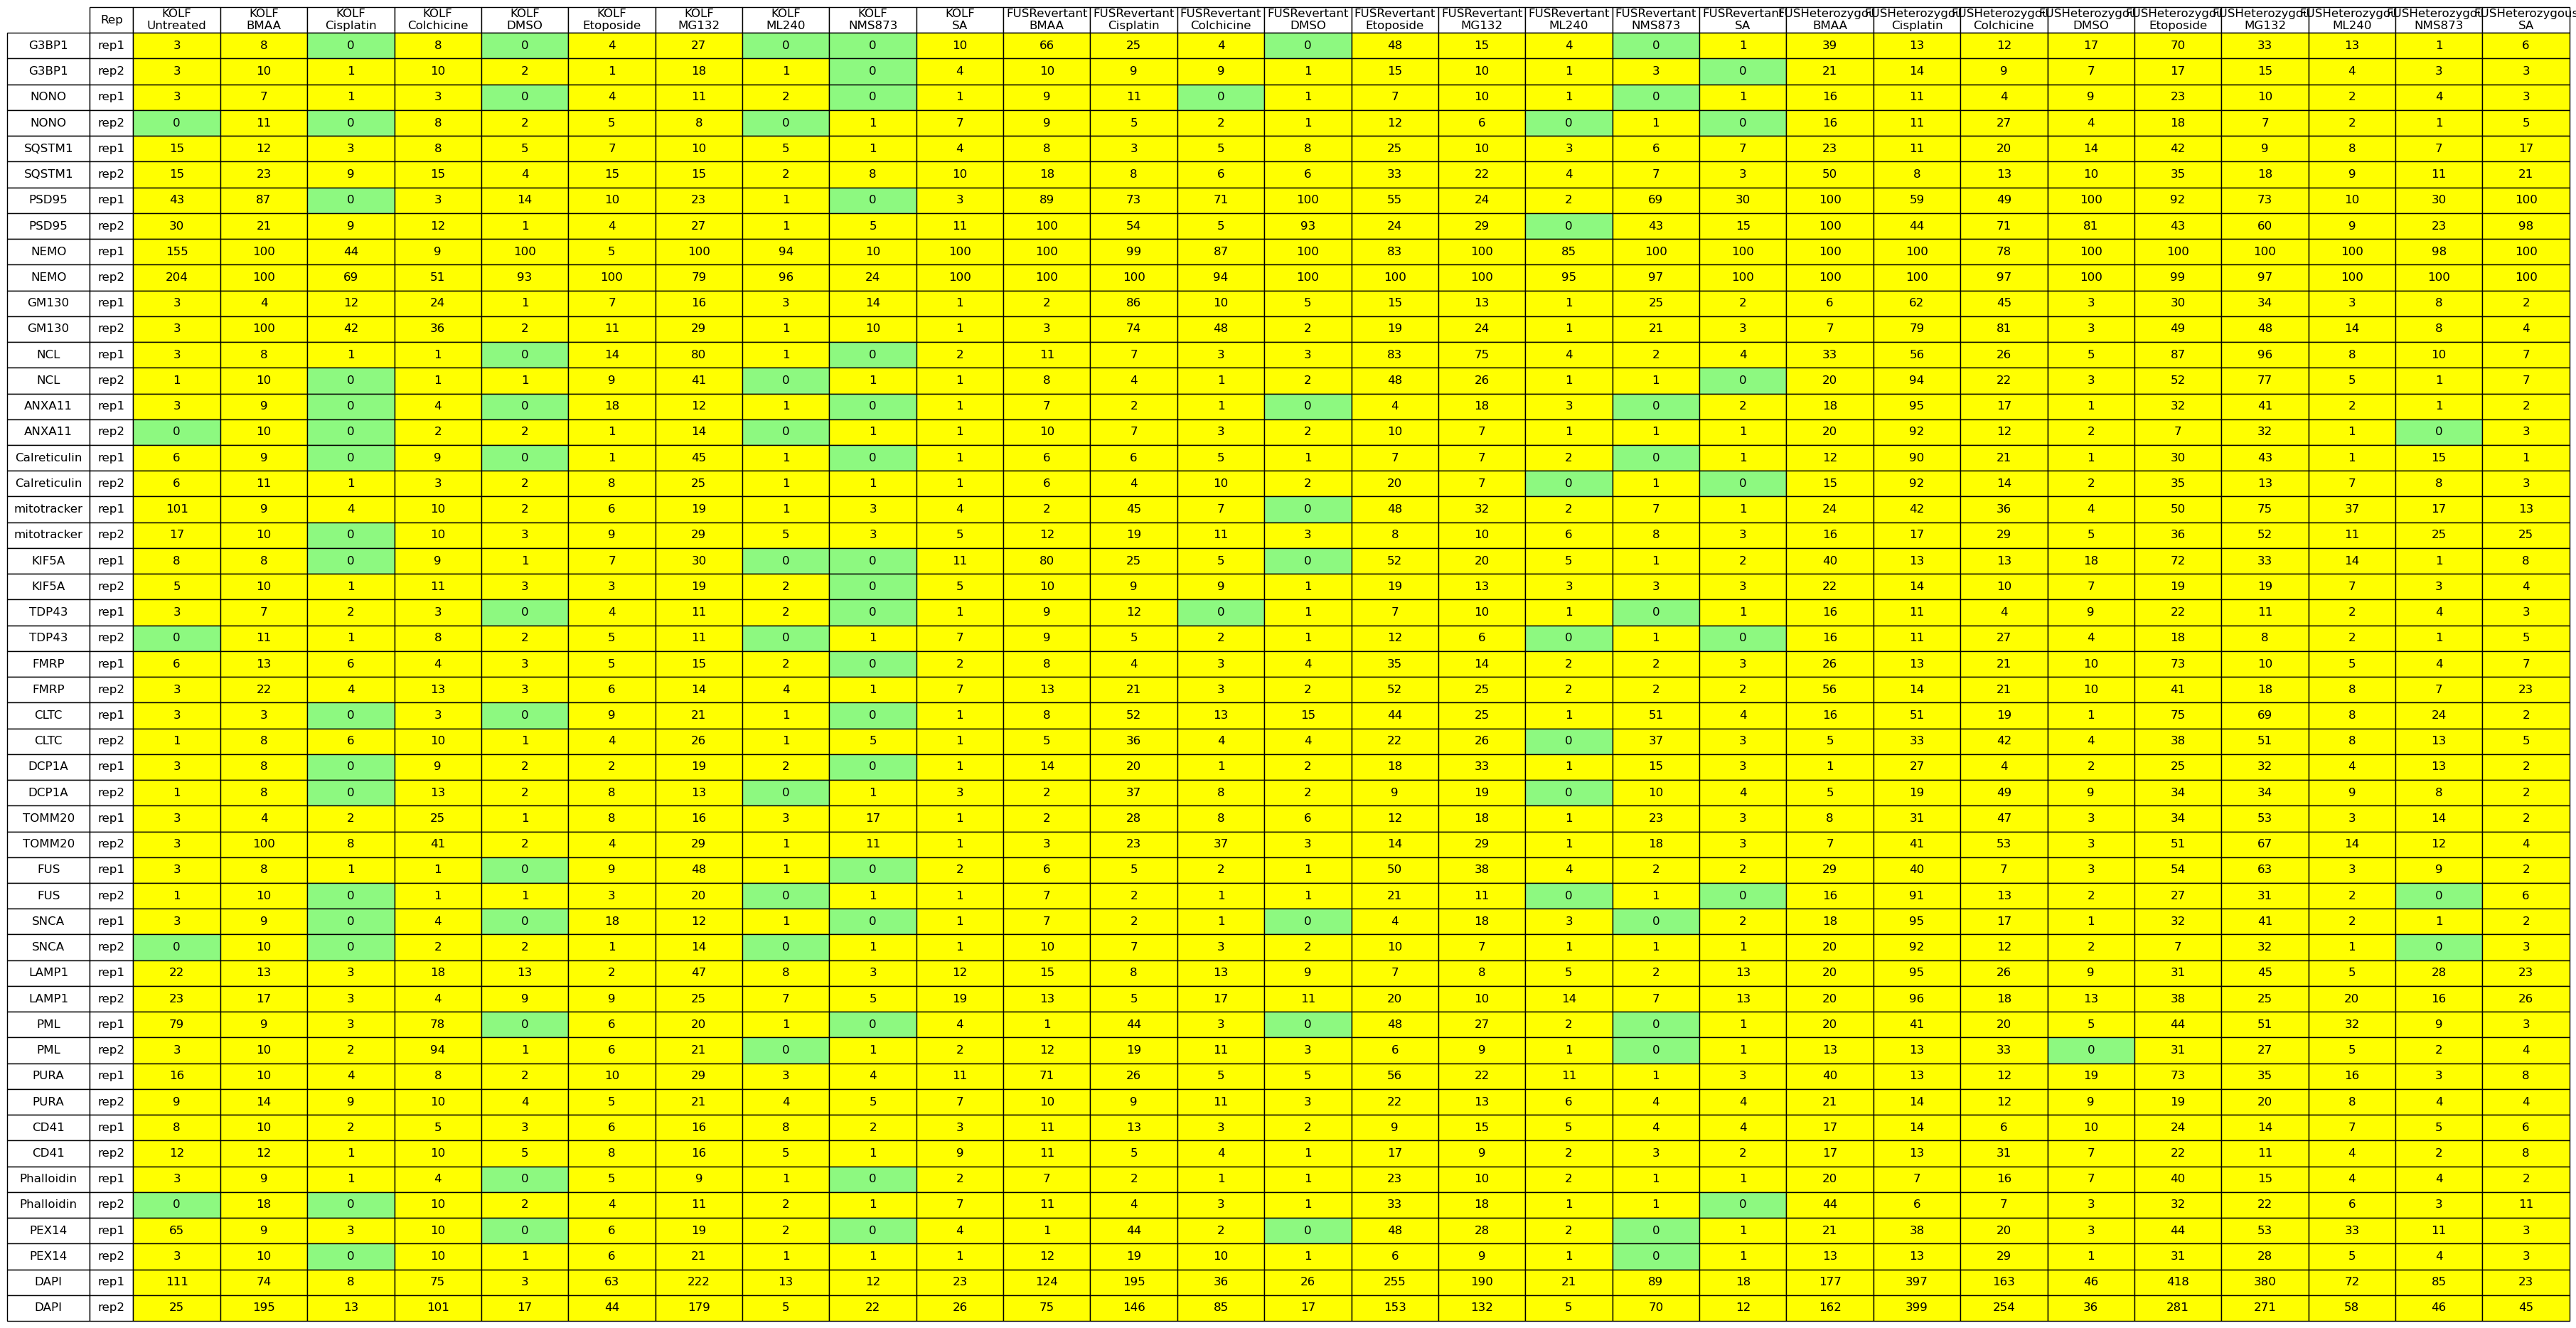

In [6]:
display_diff(batches, raws, procs, PLOT_PATH, fig_width=15)

## Variance in each batch

In [7]:
#for batch in list(range(3,9)) + ['7_16bit','8_16bit','9_16bit']:  

for batch in batches:
    with contextlib.redirect_stdout(io.StringIO()):
        var = sample_and_calc_variance(root_directory_proc, batch, 
                                       sample_size_per_markers=200, cond_count=2, rep_count=len(reps), 
                                       num_markers=len(dnls_markers))
    print(f'{batch} var: ',var)

batch1 var:  0.01627370999309101


# filtering qc
By order of filtering

## 1. % site survival after Brenner on DAPI channel
Percentage out of the total sites

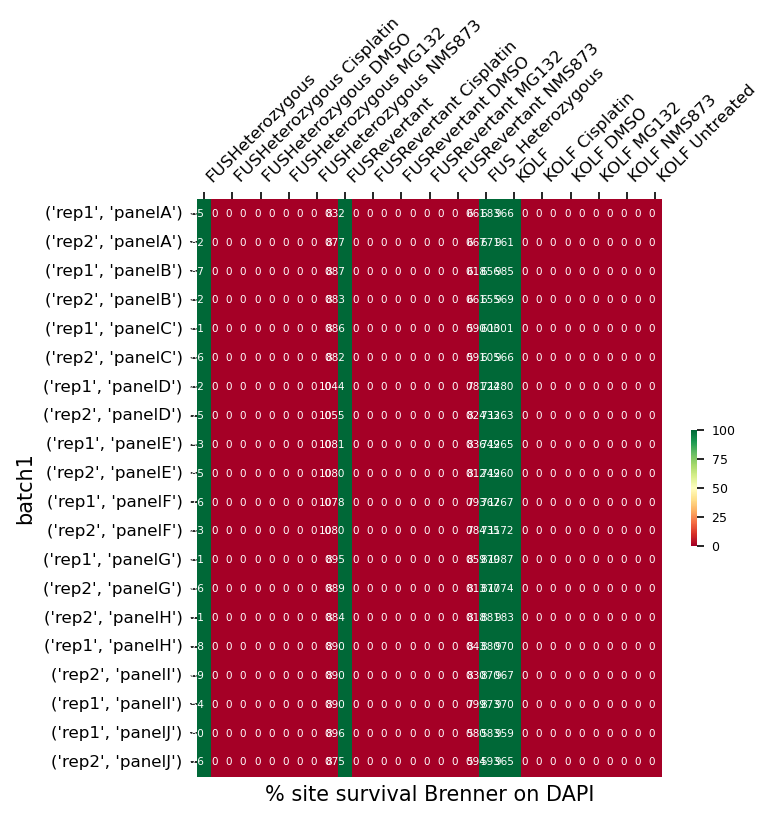

In [9]:
dapi_filter_by_brenner = show_site_survival_dapi_brenner(df_dapi,batches, fus_line_colors, fus_panels)

## 2. % Site survival after Cellpose
Percentage out of the sites that passed the previous filter. In parenthesis are absolute values.

**A site will be filtered out if Cellpose found 0 cells in it.**

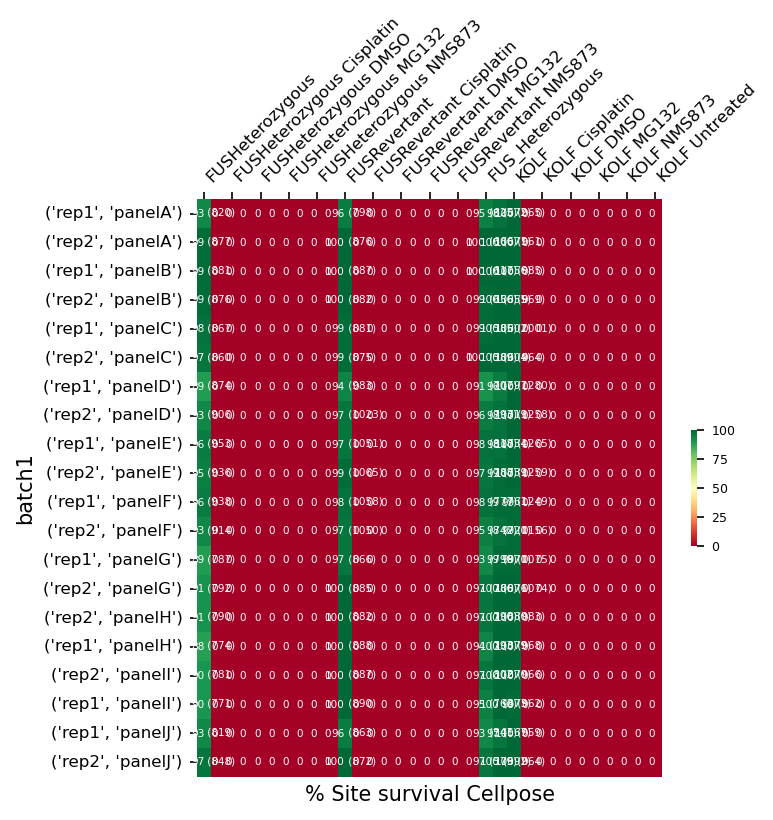

In [10]:
dapi_filter_by_cellpose = show_site_survival_dapi_cellpose(df_dapi, batches, dapi_filter_by_brenner, fus_line_colors, fus_panels)

## 3. % Site survival by tiling
Percentage out of the sites that passed the previous filter. In parenthesis are absolute values.

**A site will be filtered out if after tiling, no tile is containing at least 85% of a cell that Cellpose detected.**

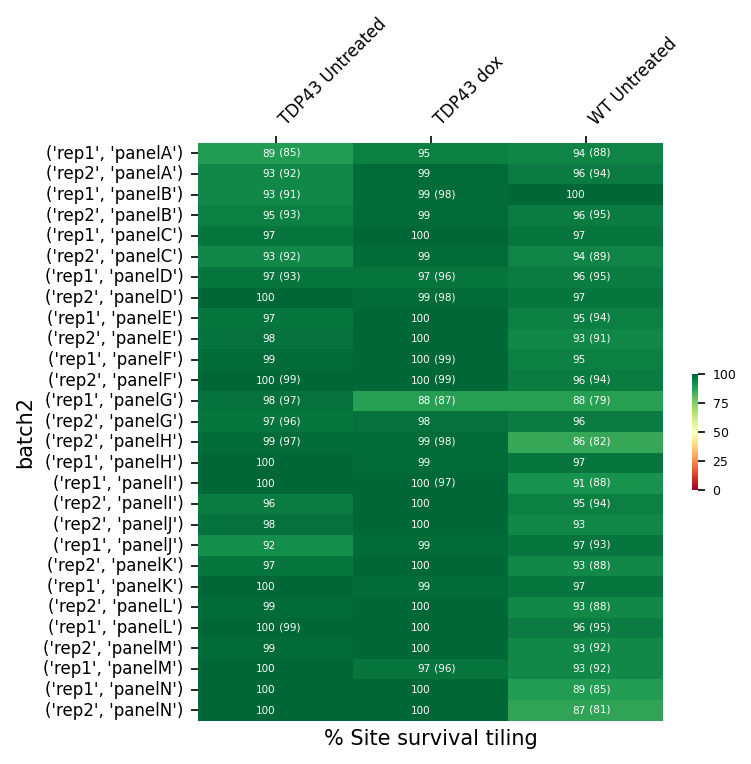

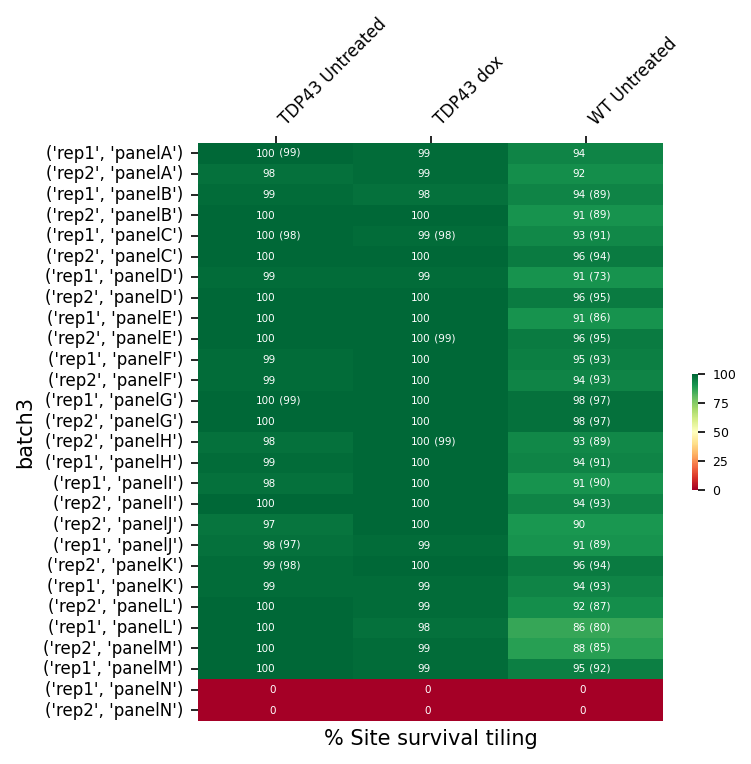

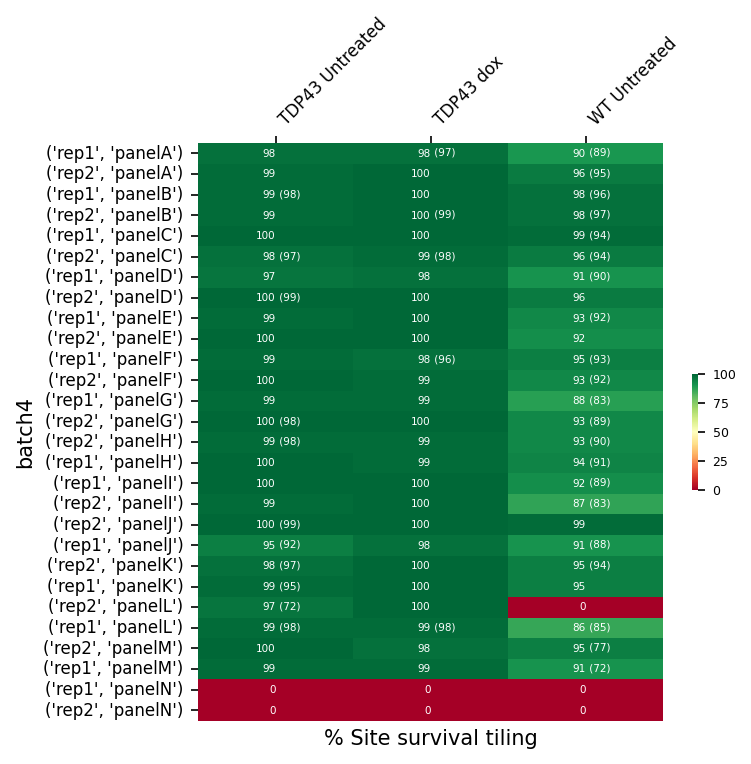

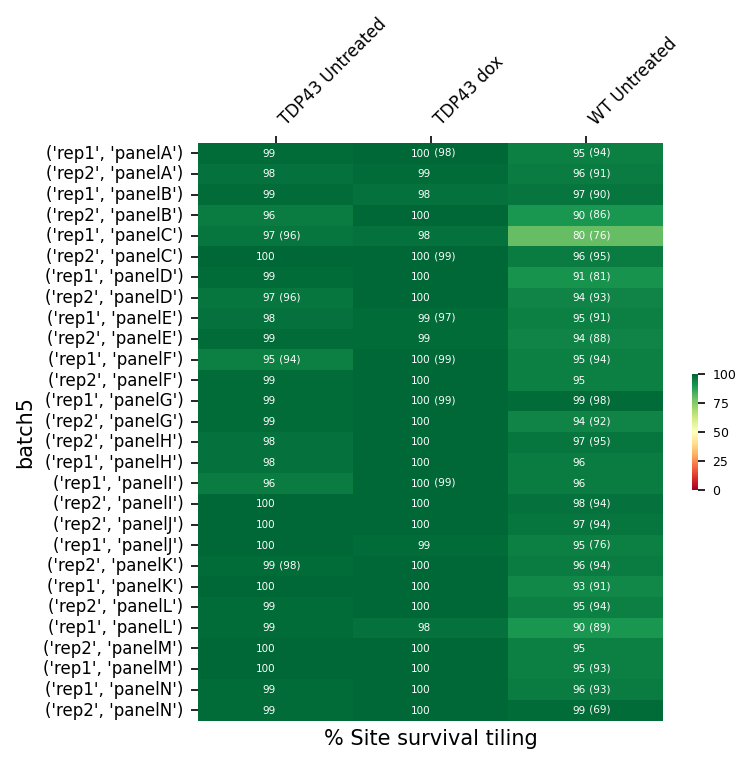

In [11]:
dapi_filter_by_tiling=show_site_survival_dapi_tiling(df_dapi, batches, dapi_filter_by_cellpose, dnls_line_colors, dnls_panels)

## 4. % Site survival after Brenner on target channel
Percentage out of the sites that passed the previous filter. In parenthesis are absolute values (if different than the percentages).

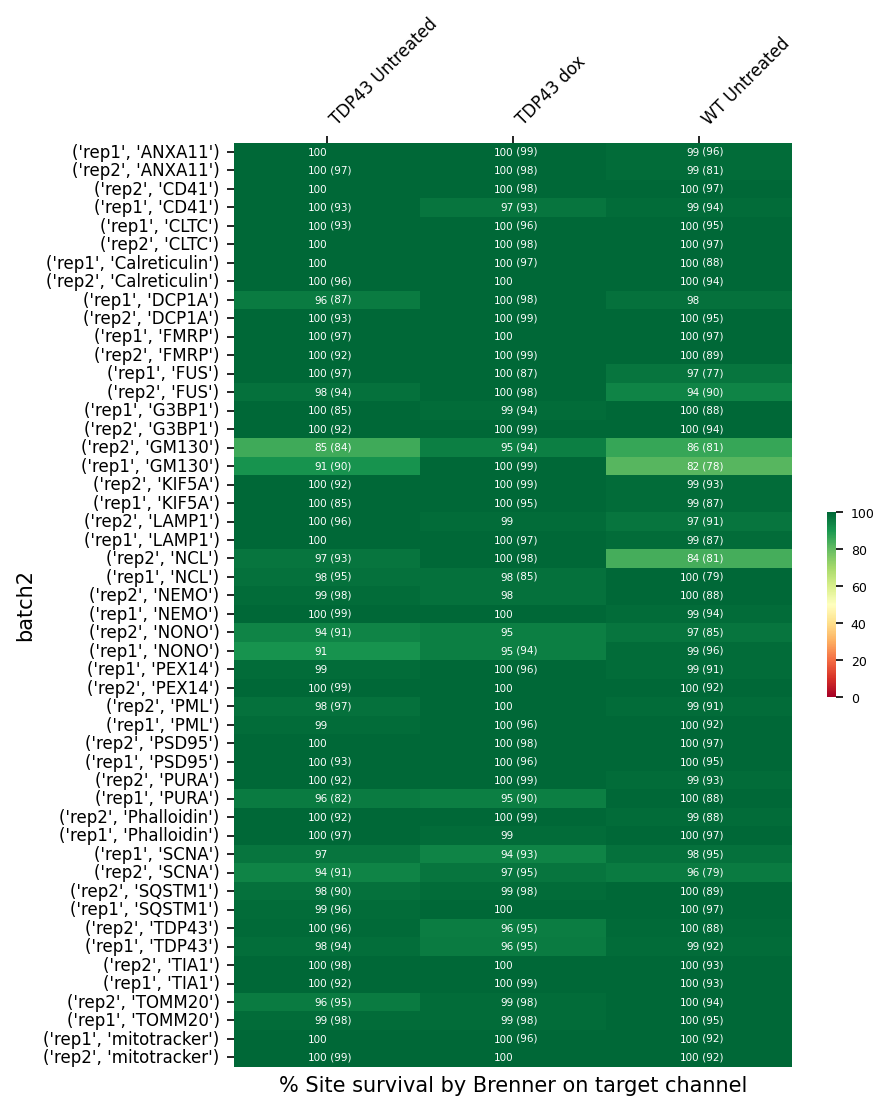

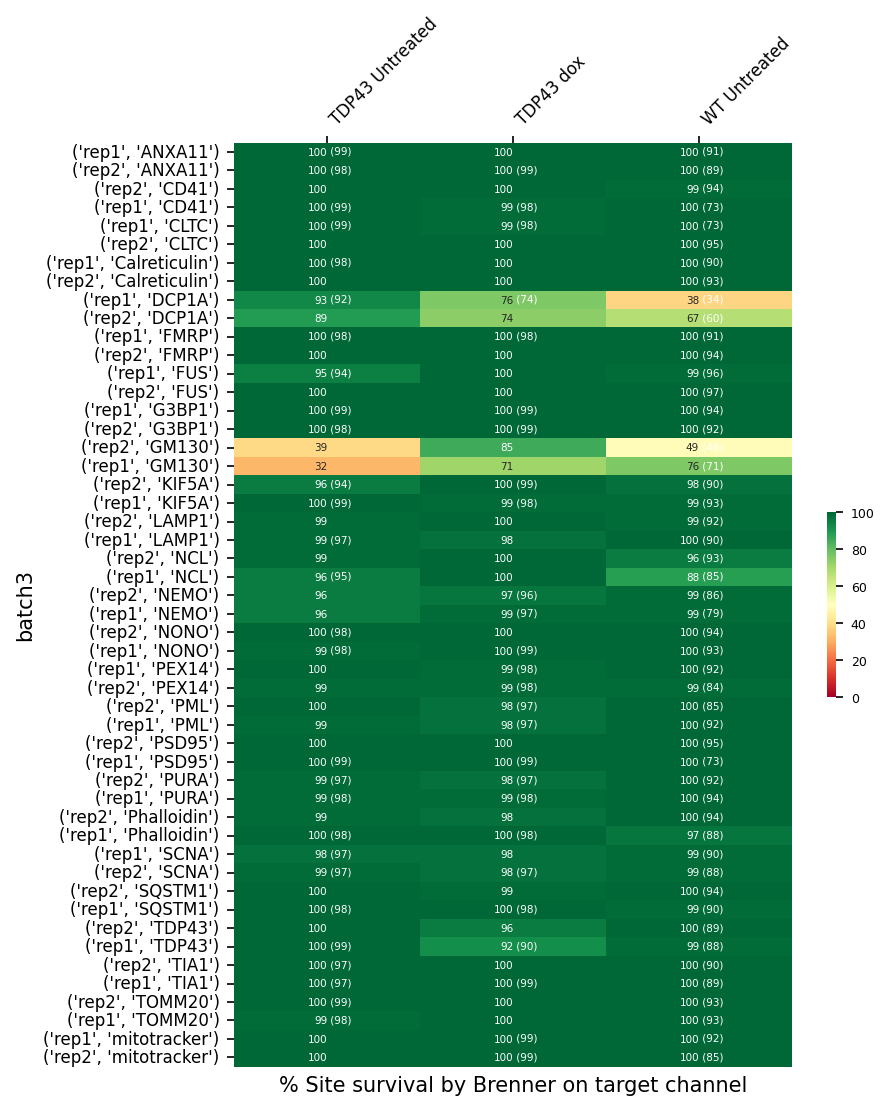

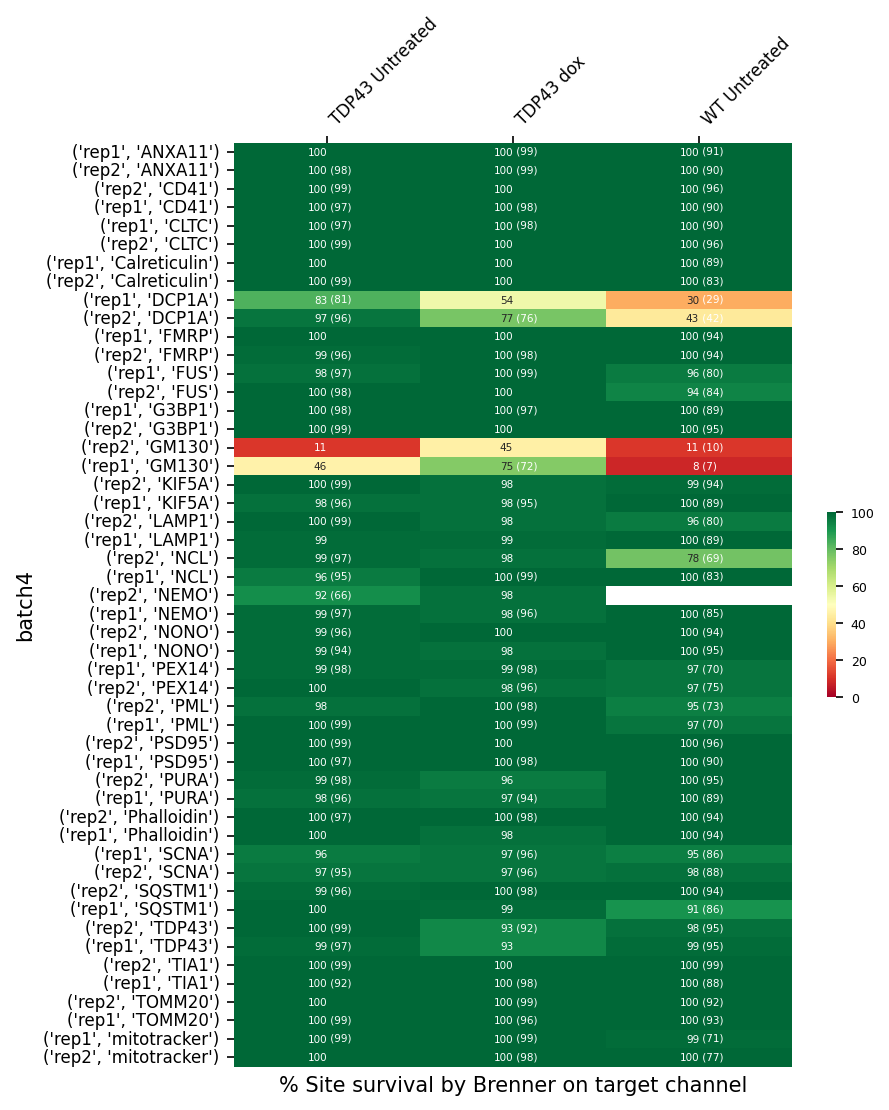

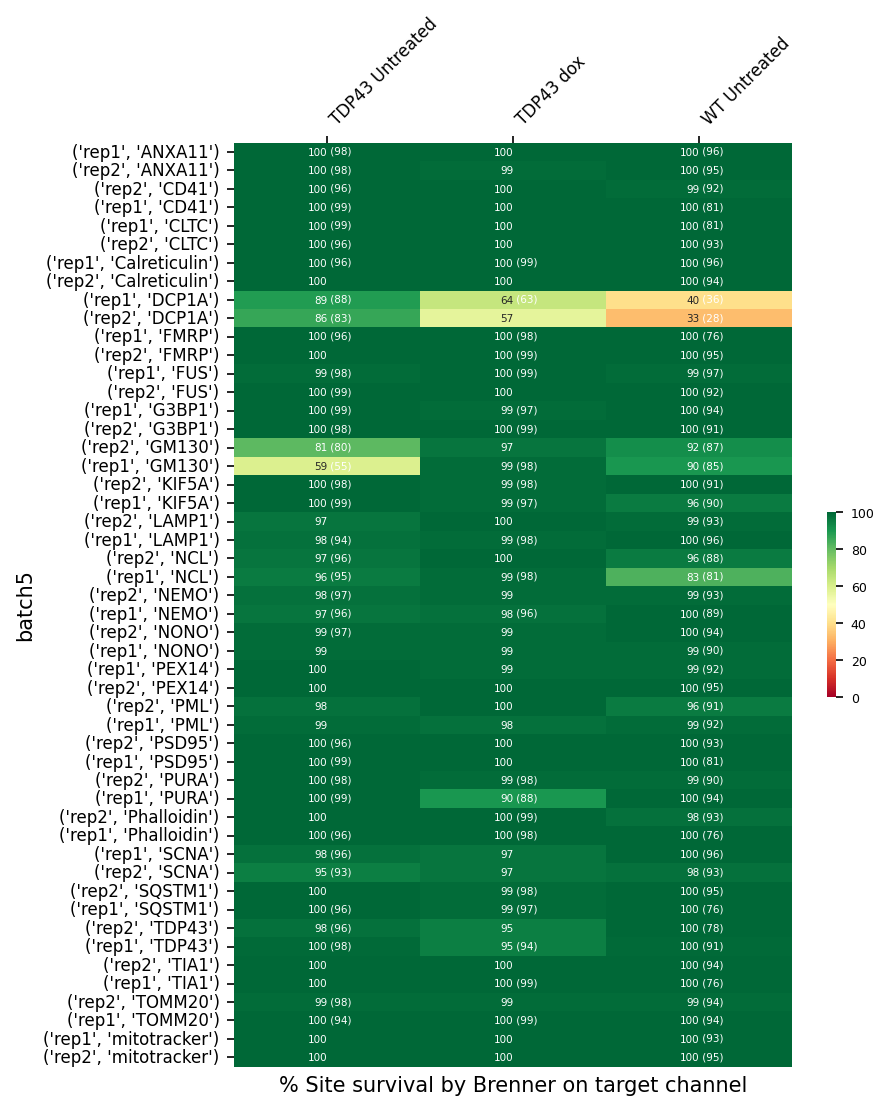

In [12]:
show_site_survival_target_brenner(df_dapi, df_target, dapi_filter_by_tiling)

### Numbers!

1. Total number of tiles: for each condition, we can know how many **tiles** we have --> number of data points for the model to train and infer on --> number of points in UMAPs..
2. Total number of whole cells: for each condtion, we can know how many **whole cells** we have

In [5]:
names = ['Total number of tiles', 'Total number of whole cells']
stats = ['n_valid_tiles','site_whole_cells_counts_sum','site_cell_count','site_cell_count_sum']
total_sum = calc_total_sums(df_target, df_dapi, stats)
    

# for stat, name in zip(stats[:2], names):
#     to_heatmap = total_sum.rename(columns={stat:'index'})
#     plot_filtering_heatmap(to_heatmap, extra_index='marker', vmin=None, vmax=None,
#                           xlabel = name, show_sum=True, figsize=(4,8))

In [7]:
total_sum.sum()

batch                          batch2batch2batch2batch2batch2batch2batch3batc...
cell_line_cond                 TDP43 UntreatedTDP43 UntreatedTDP43 doxTDP43 d...
rep                            rep1rep2rep1rep2rep1rep2rep1rep2rep1rep2rep1re...
panel                          panelApanelApanelApanelApanelApanelApanelApane...
n_valid_tiles                                                             328226
site_whole_cells_counts_sum                                             364866.0
site_cell_count                                                         928299.0
site_cell_count_sum                                                    1553445.0
marker                         G3BP1G3BP1G3BP1G3BP1G3BP1G3BP1G3BP1G3BP1G3BP1G...
dtype: object

In [14]:
show_total_sum_tables(total_sum)

# <font color='red'>Number of Cells in Site for each batch and cell line</font>

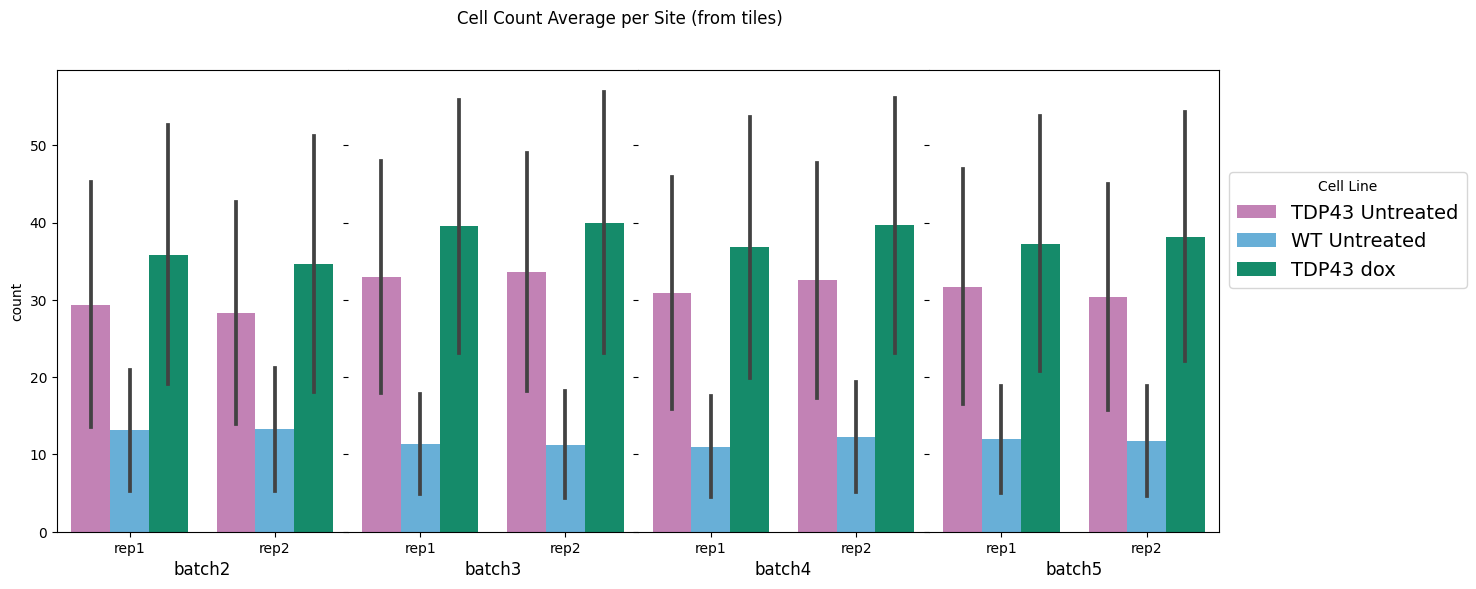

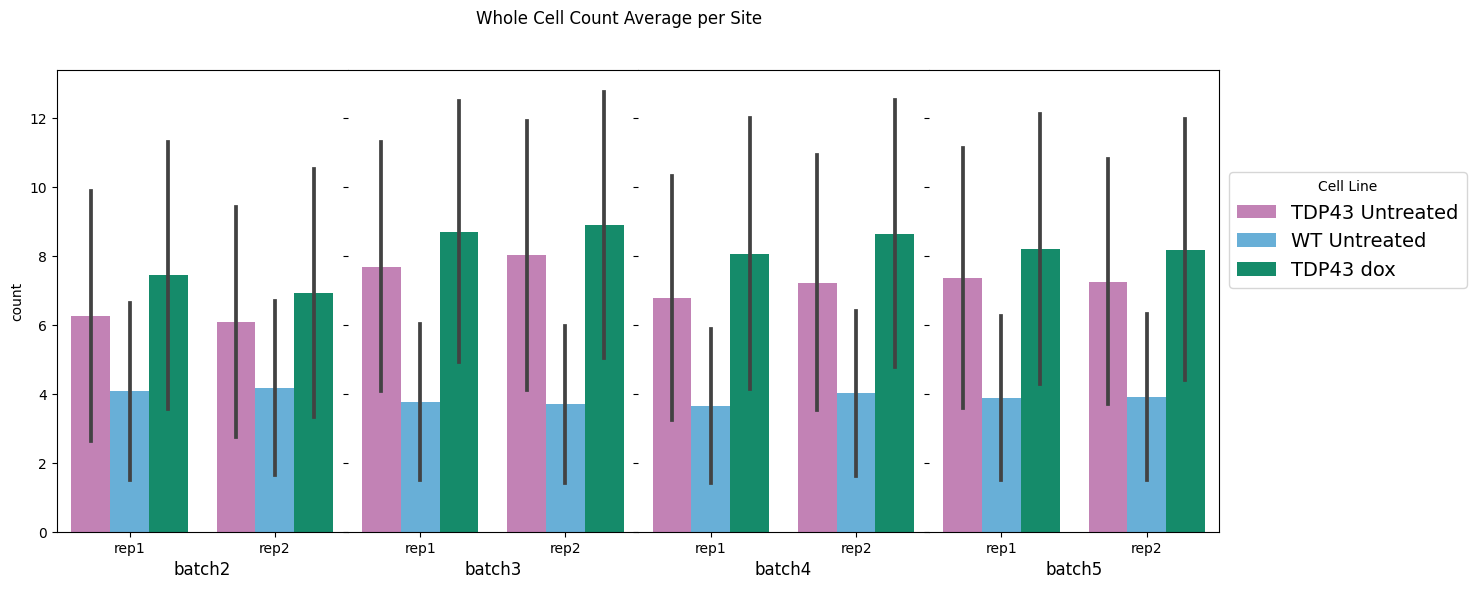

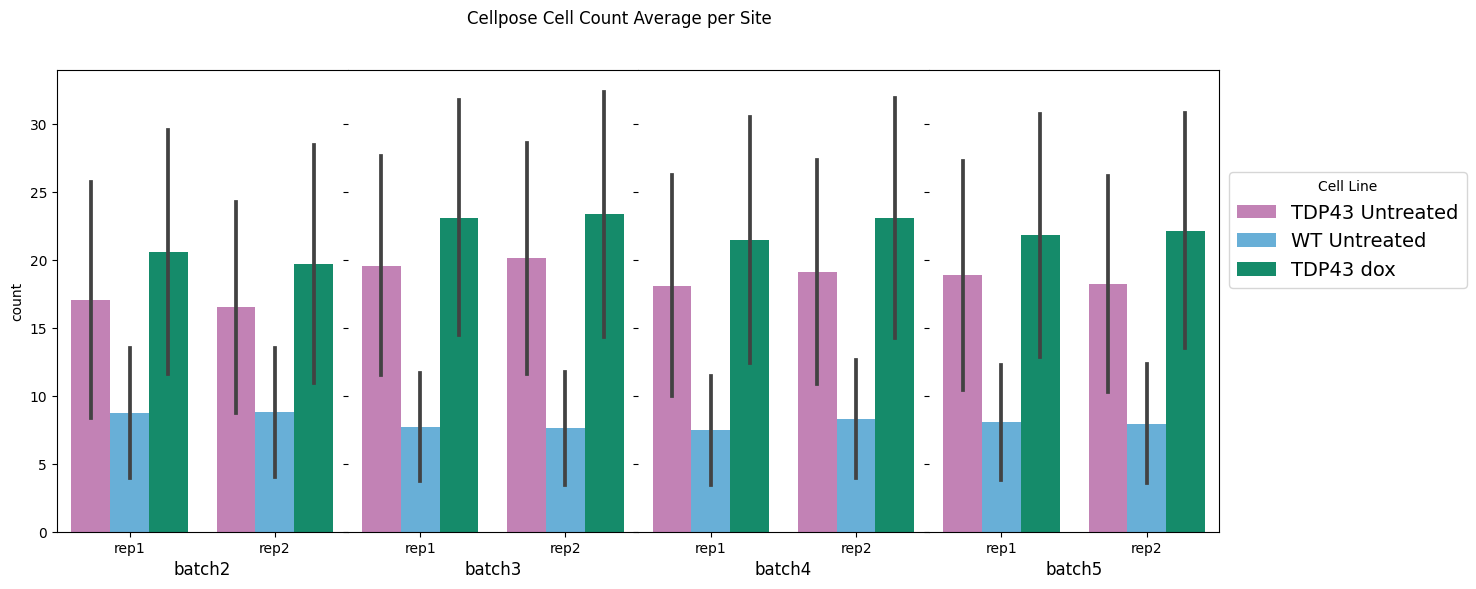

In [15]:
df_no_empty_sites = df_dapi[df_dapi.n_valid_tiles !=0]
plot_cell_count(df_no_empty_sites, dnls_lines_order, dnls_custom_palette, y='site_cell_count_sum', 
                title='Cell Count Average per Site (from tiles)')

plot_cell_count(df_no_empty_sites, dnls_lines_order, dnls_custom_palette, y='site_whole_cells_counts_sum',
                title='Whole Cell Count Average per Site')

plot_cell_count(df_no_empty_sites, dnls_lines_order, dnls_custom_palette, y='site_cell_count',
               title='Cellpose Cell Count Average per Site')


# <font color='blue'>number of valid tiles per image (site)</font>


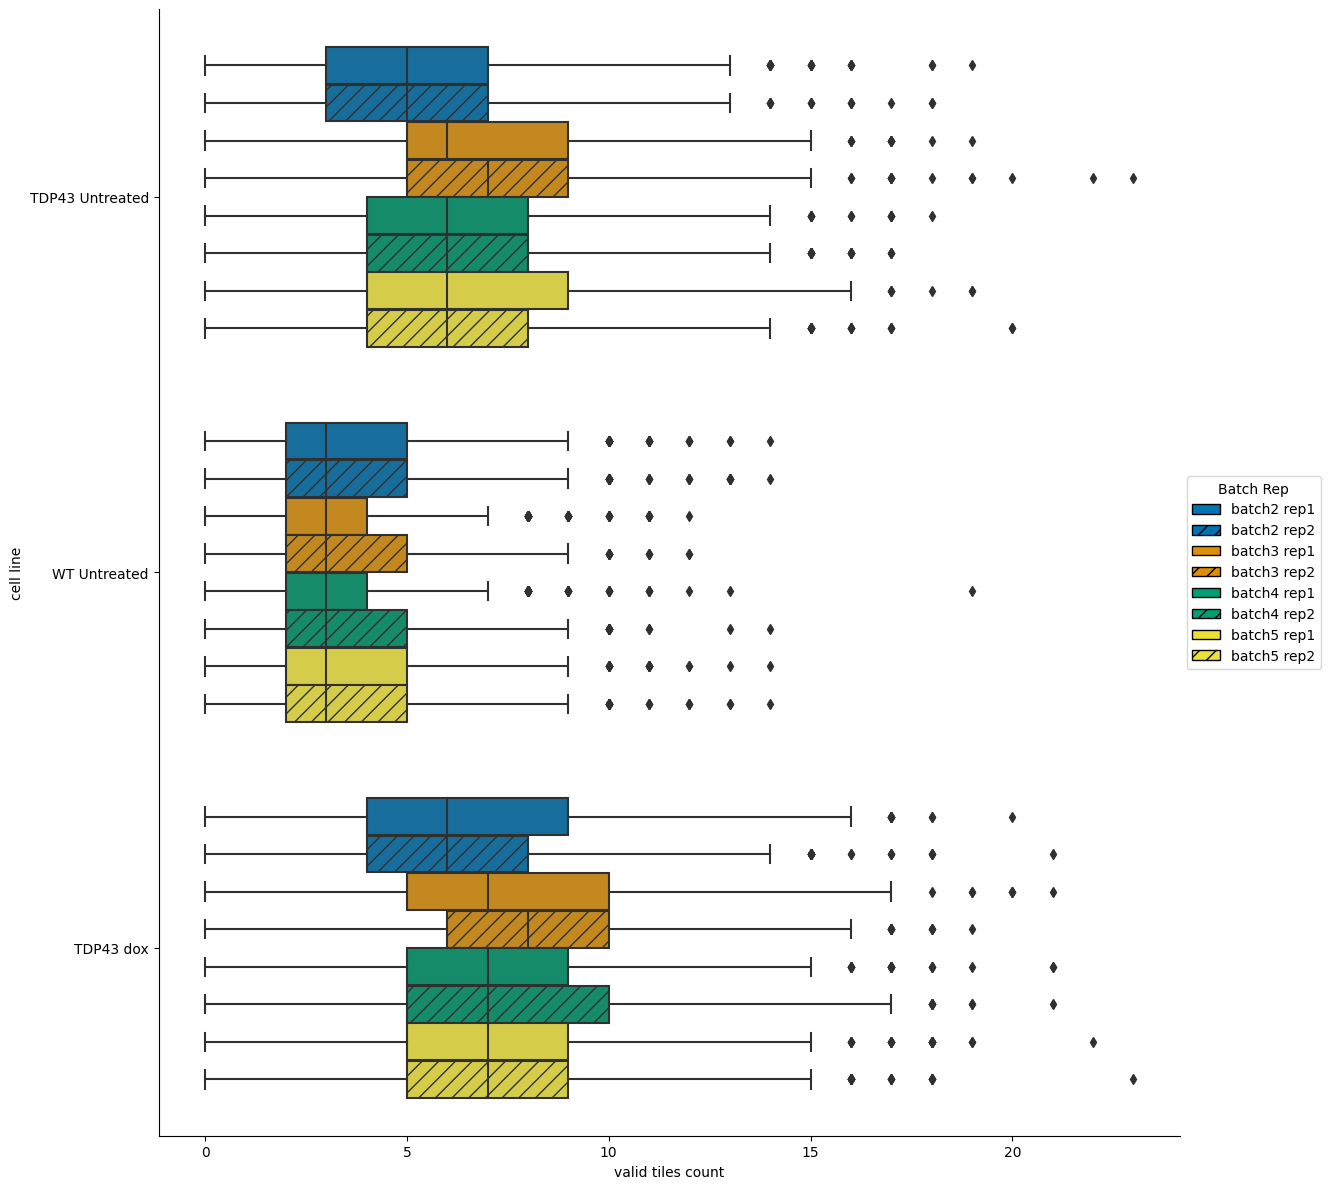

In [16]:
plot_catplot(df_dapi, custom_palette,reps, x='n_valid_tiles', x_title='valid tiles count', batch_min=2, batch_max=5)


## <font color='purple'>Heatmap QC per batch, panel and cell line(tiles that passed QC condition)  </font>


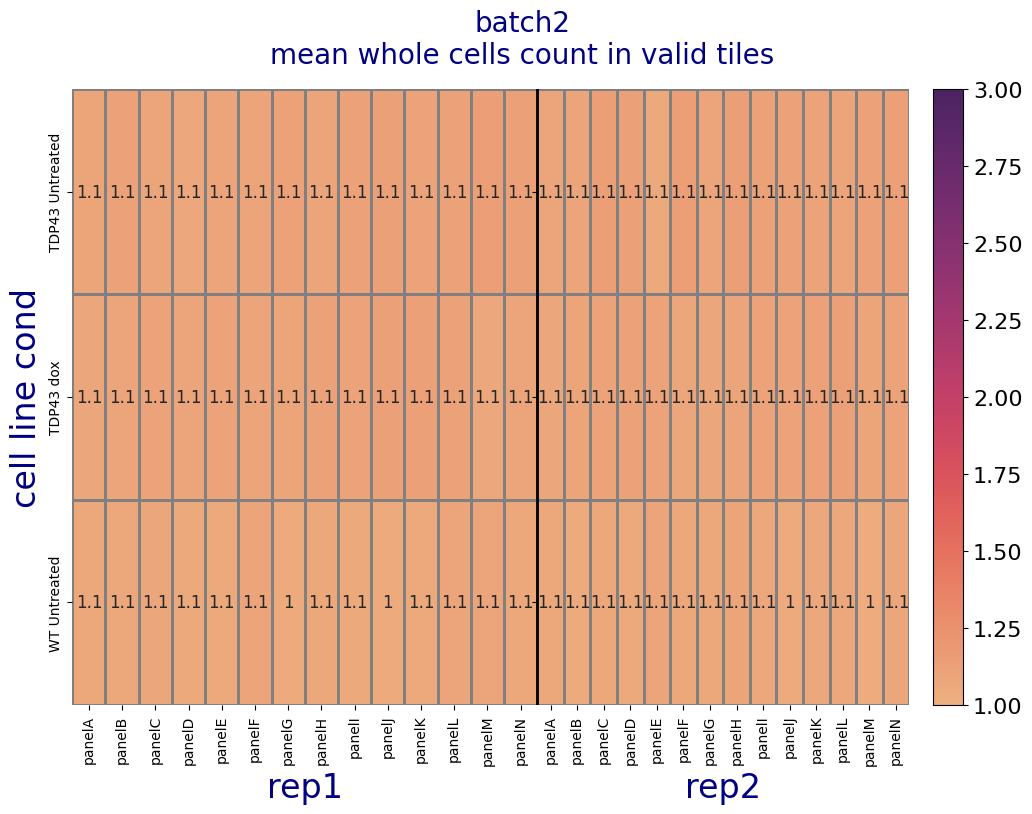

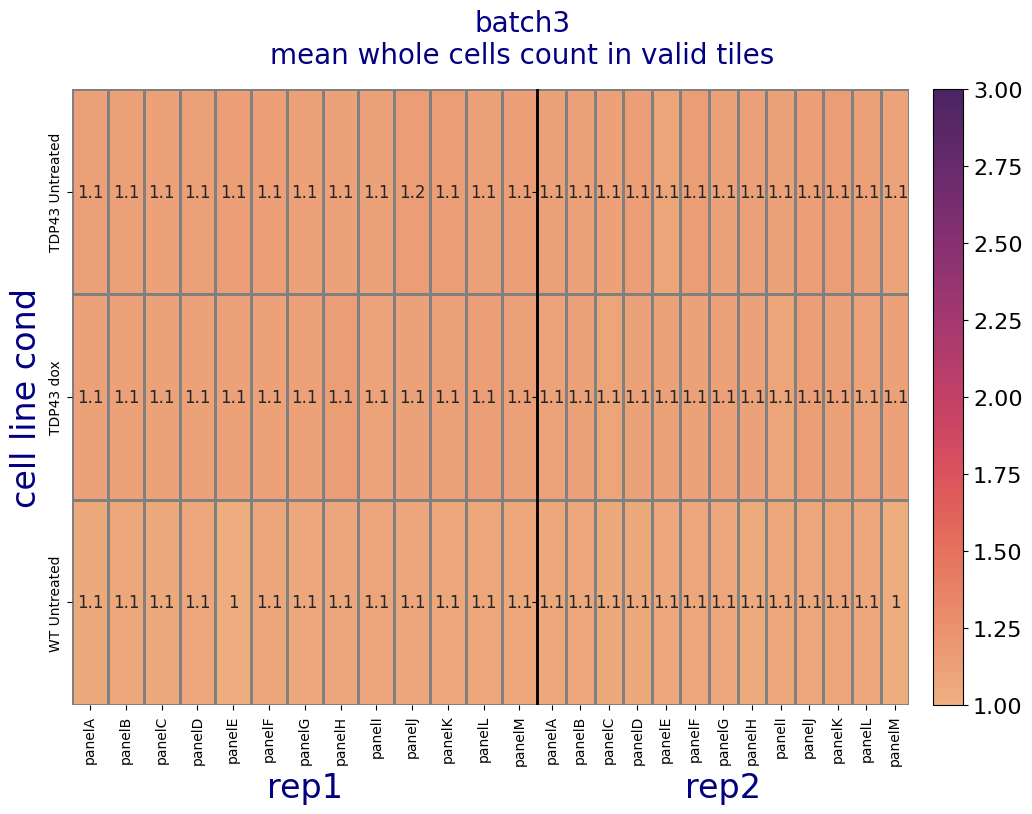

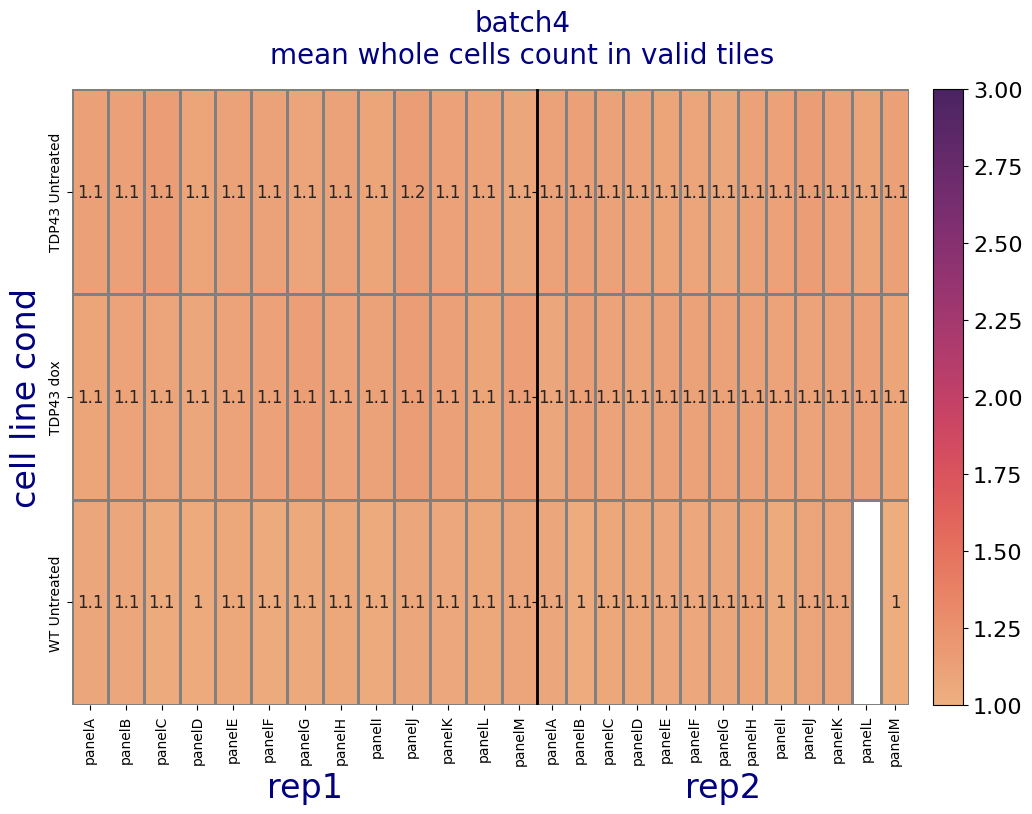

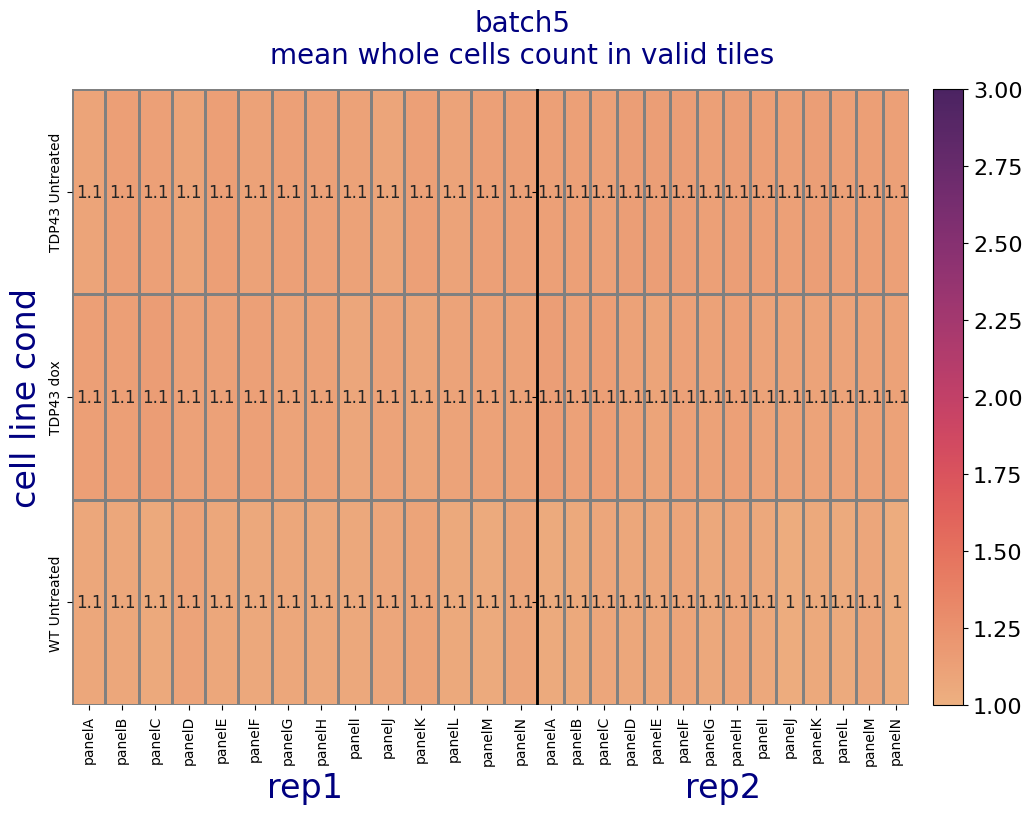

In [17]:
plot_hm(df_dapi, split_by='rep', rows='cell_line_cond', columns='panel')

# Assessing Staining Reproducibility and Outliers

batch2


/home/labs/hornsteinlab/Collaboration/MOmaps_Noam/MOmaps/src/common/lib/images_qc.py:914: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


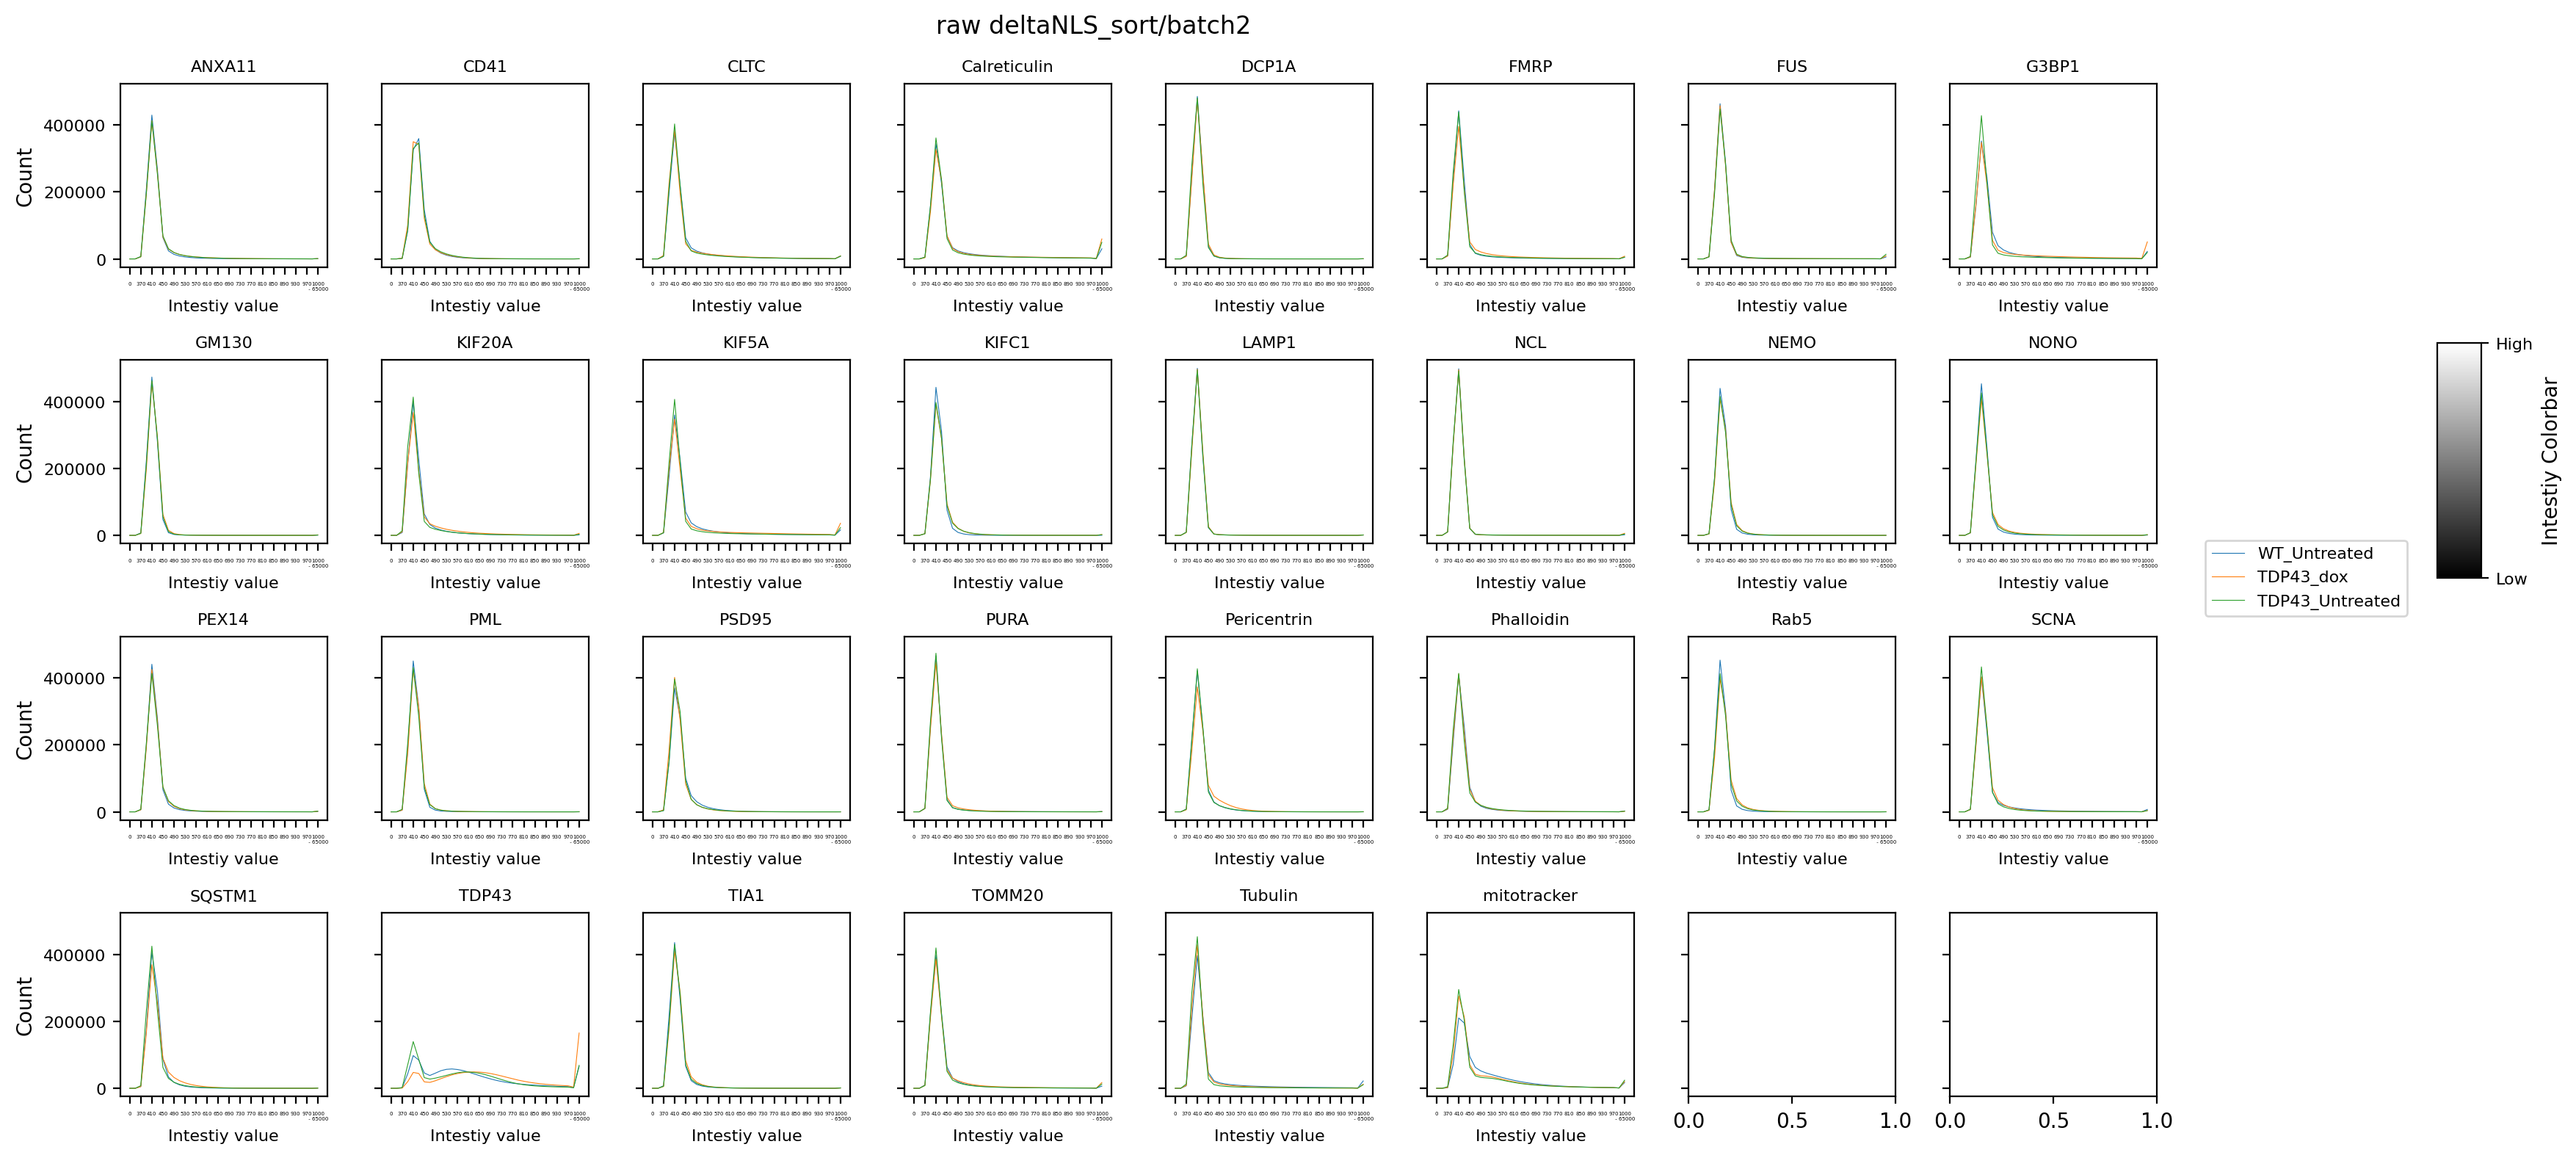

/home/labs/hornsteinlab/Collaboration/MOmaps/anaconda3/momaps_37/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


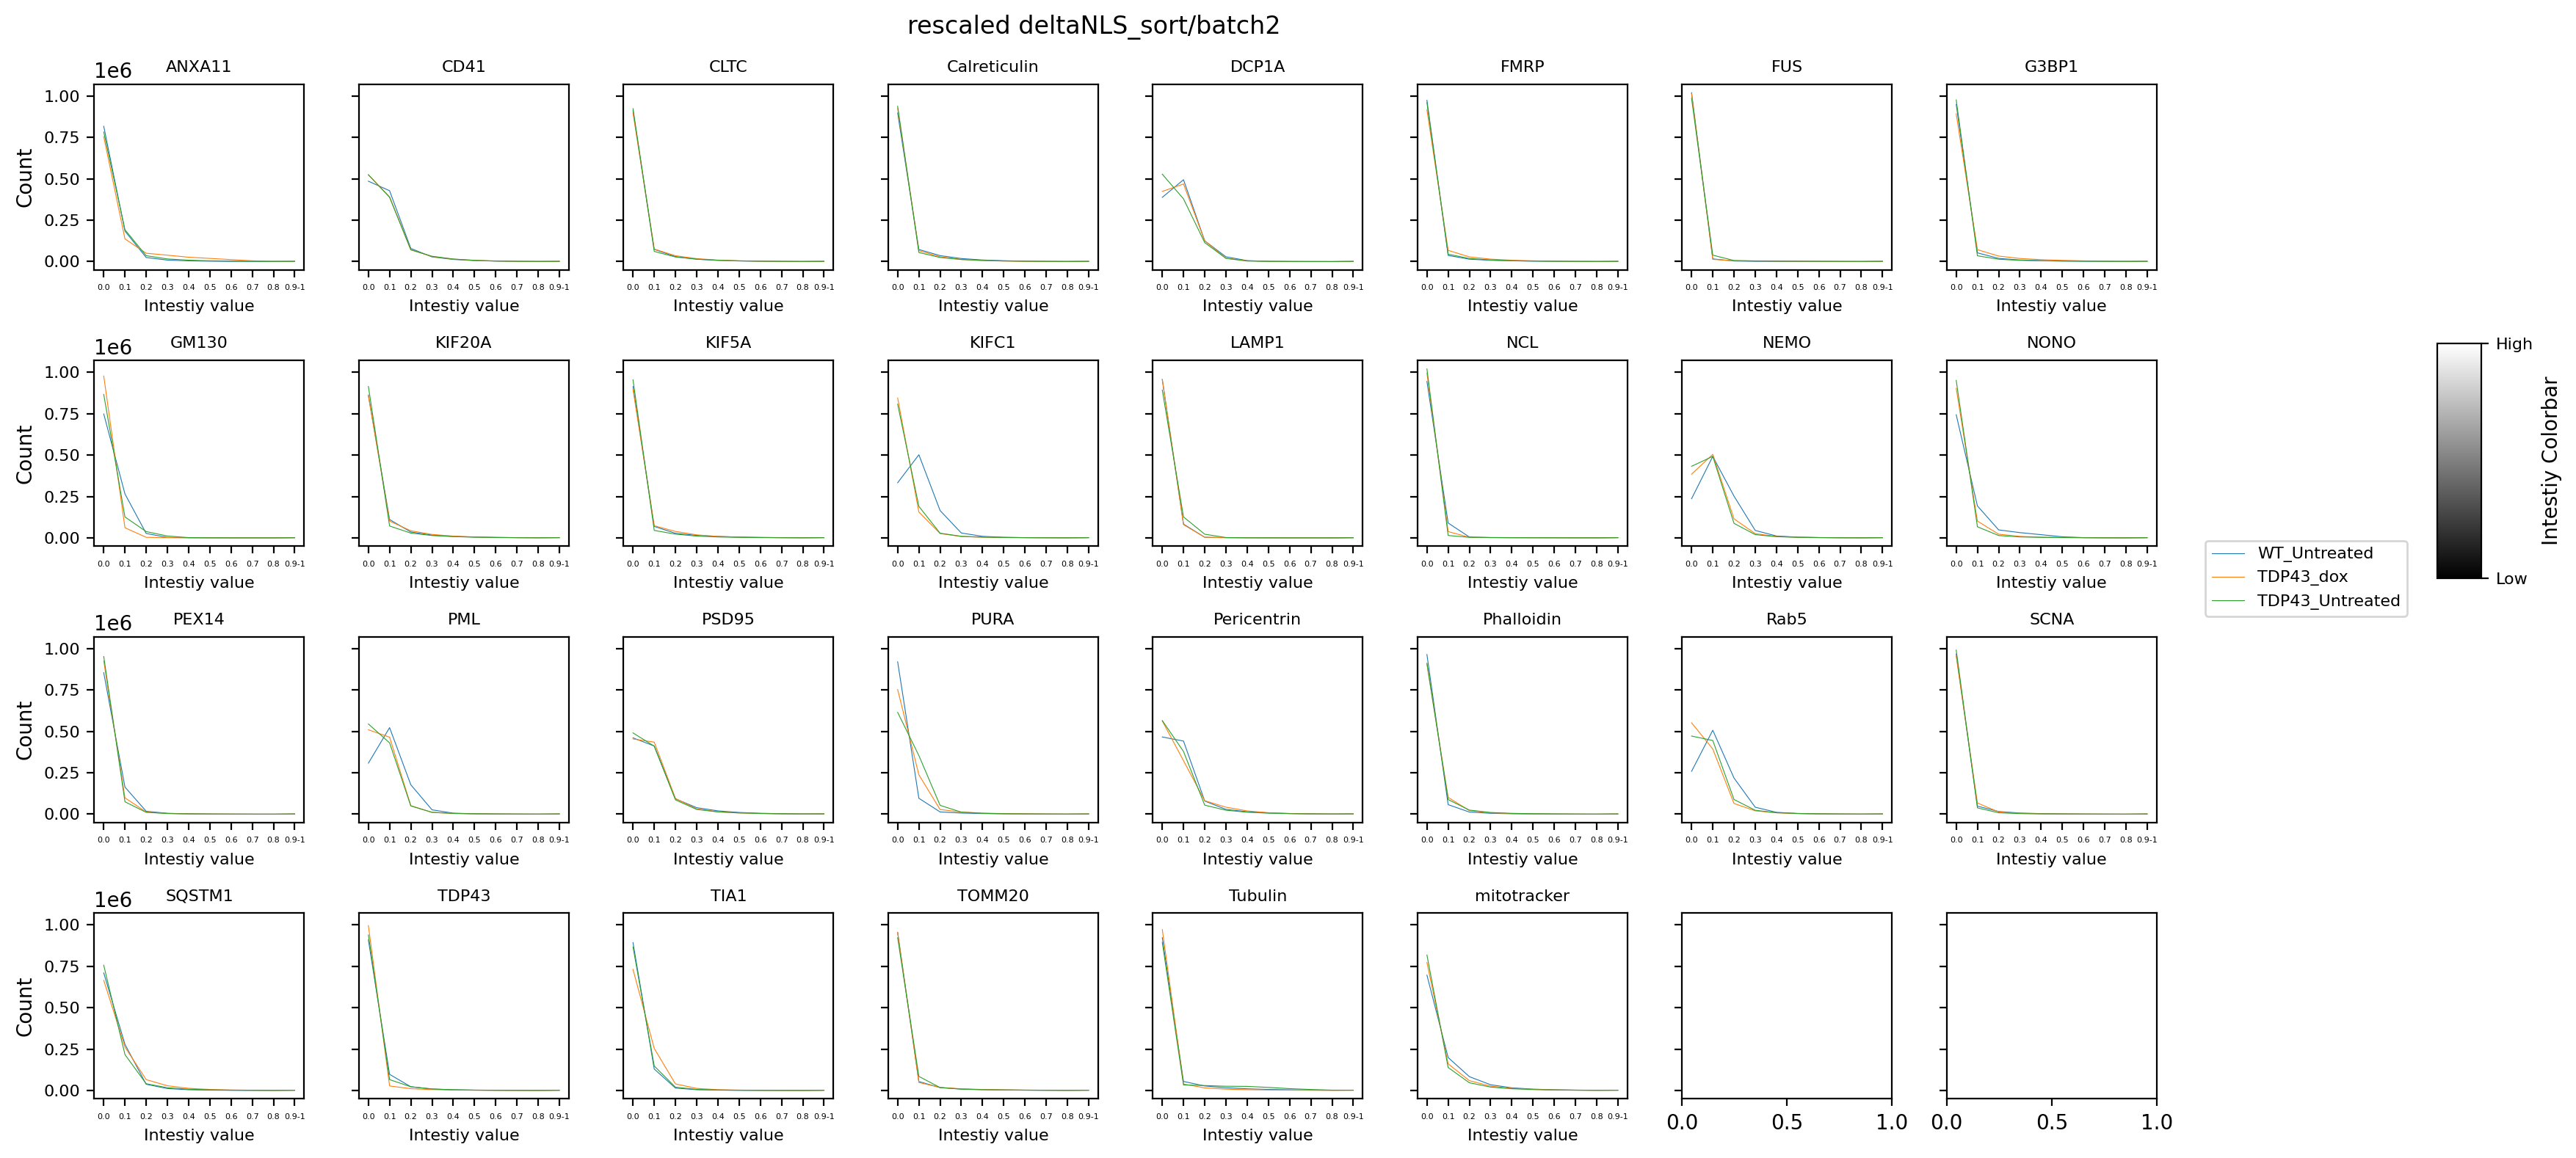

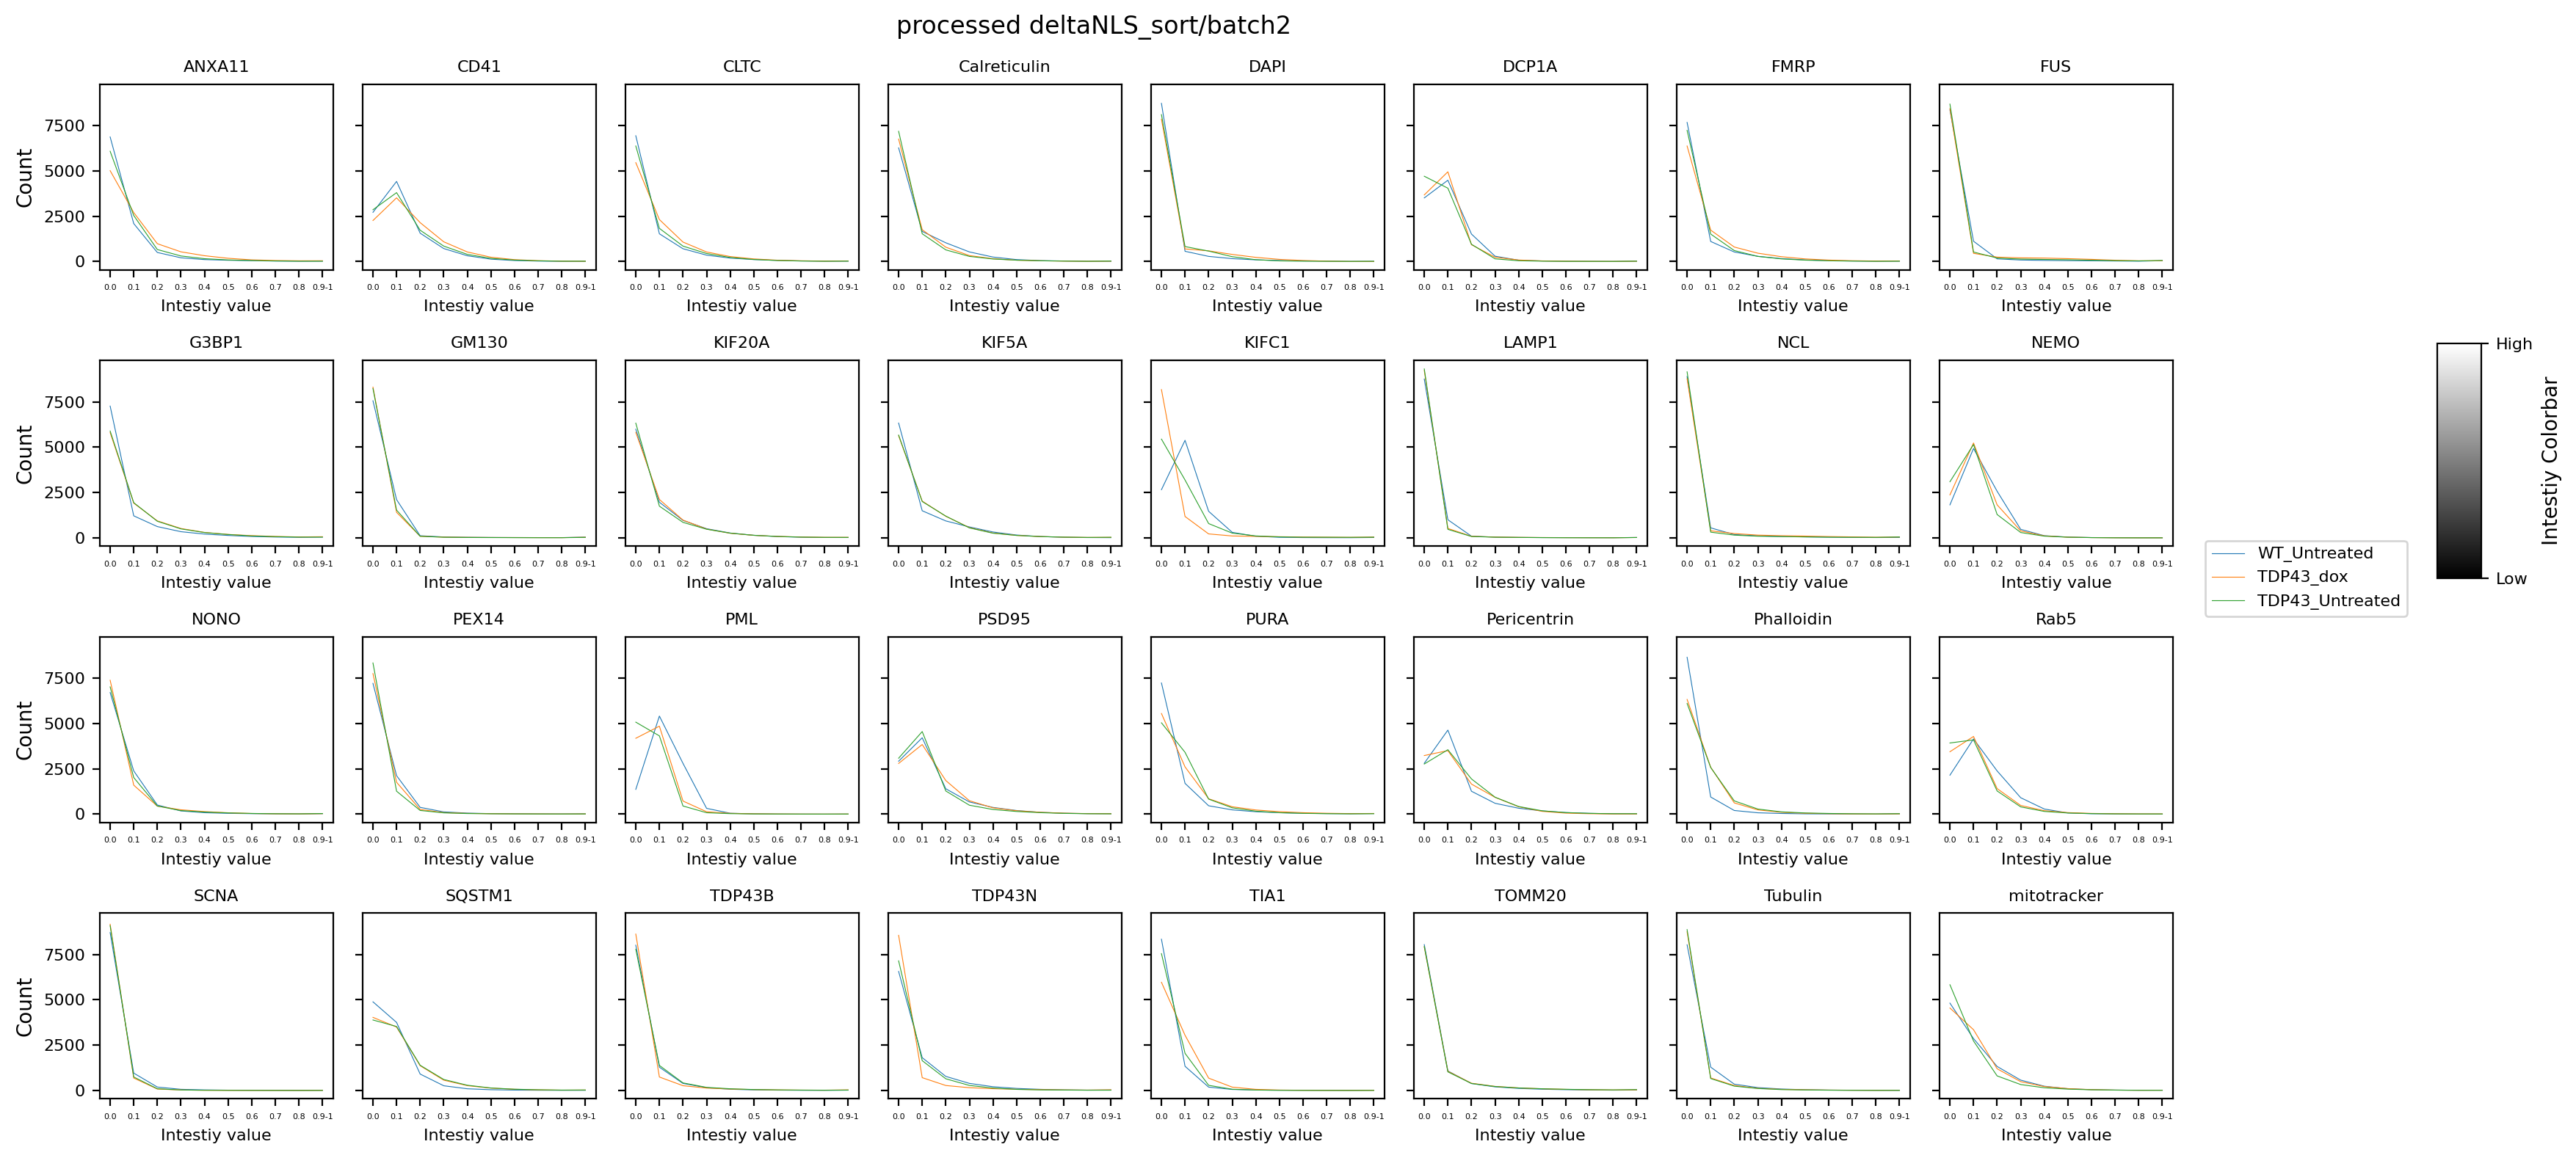

batch3


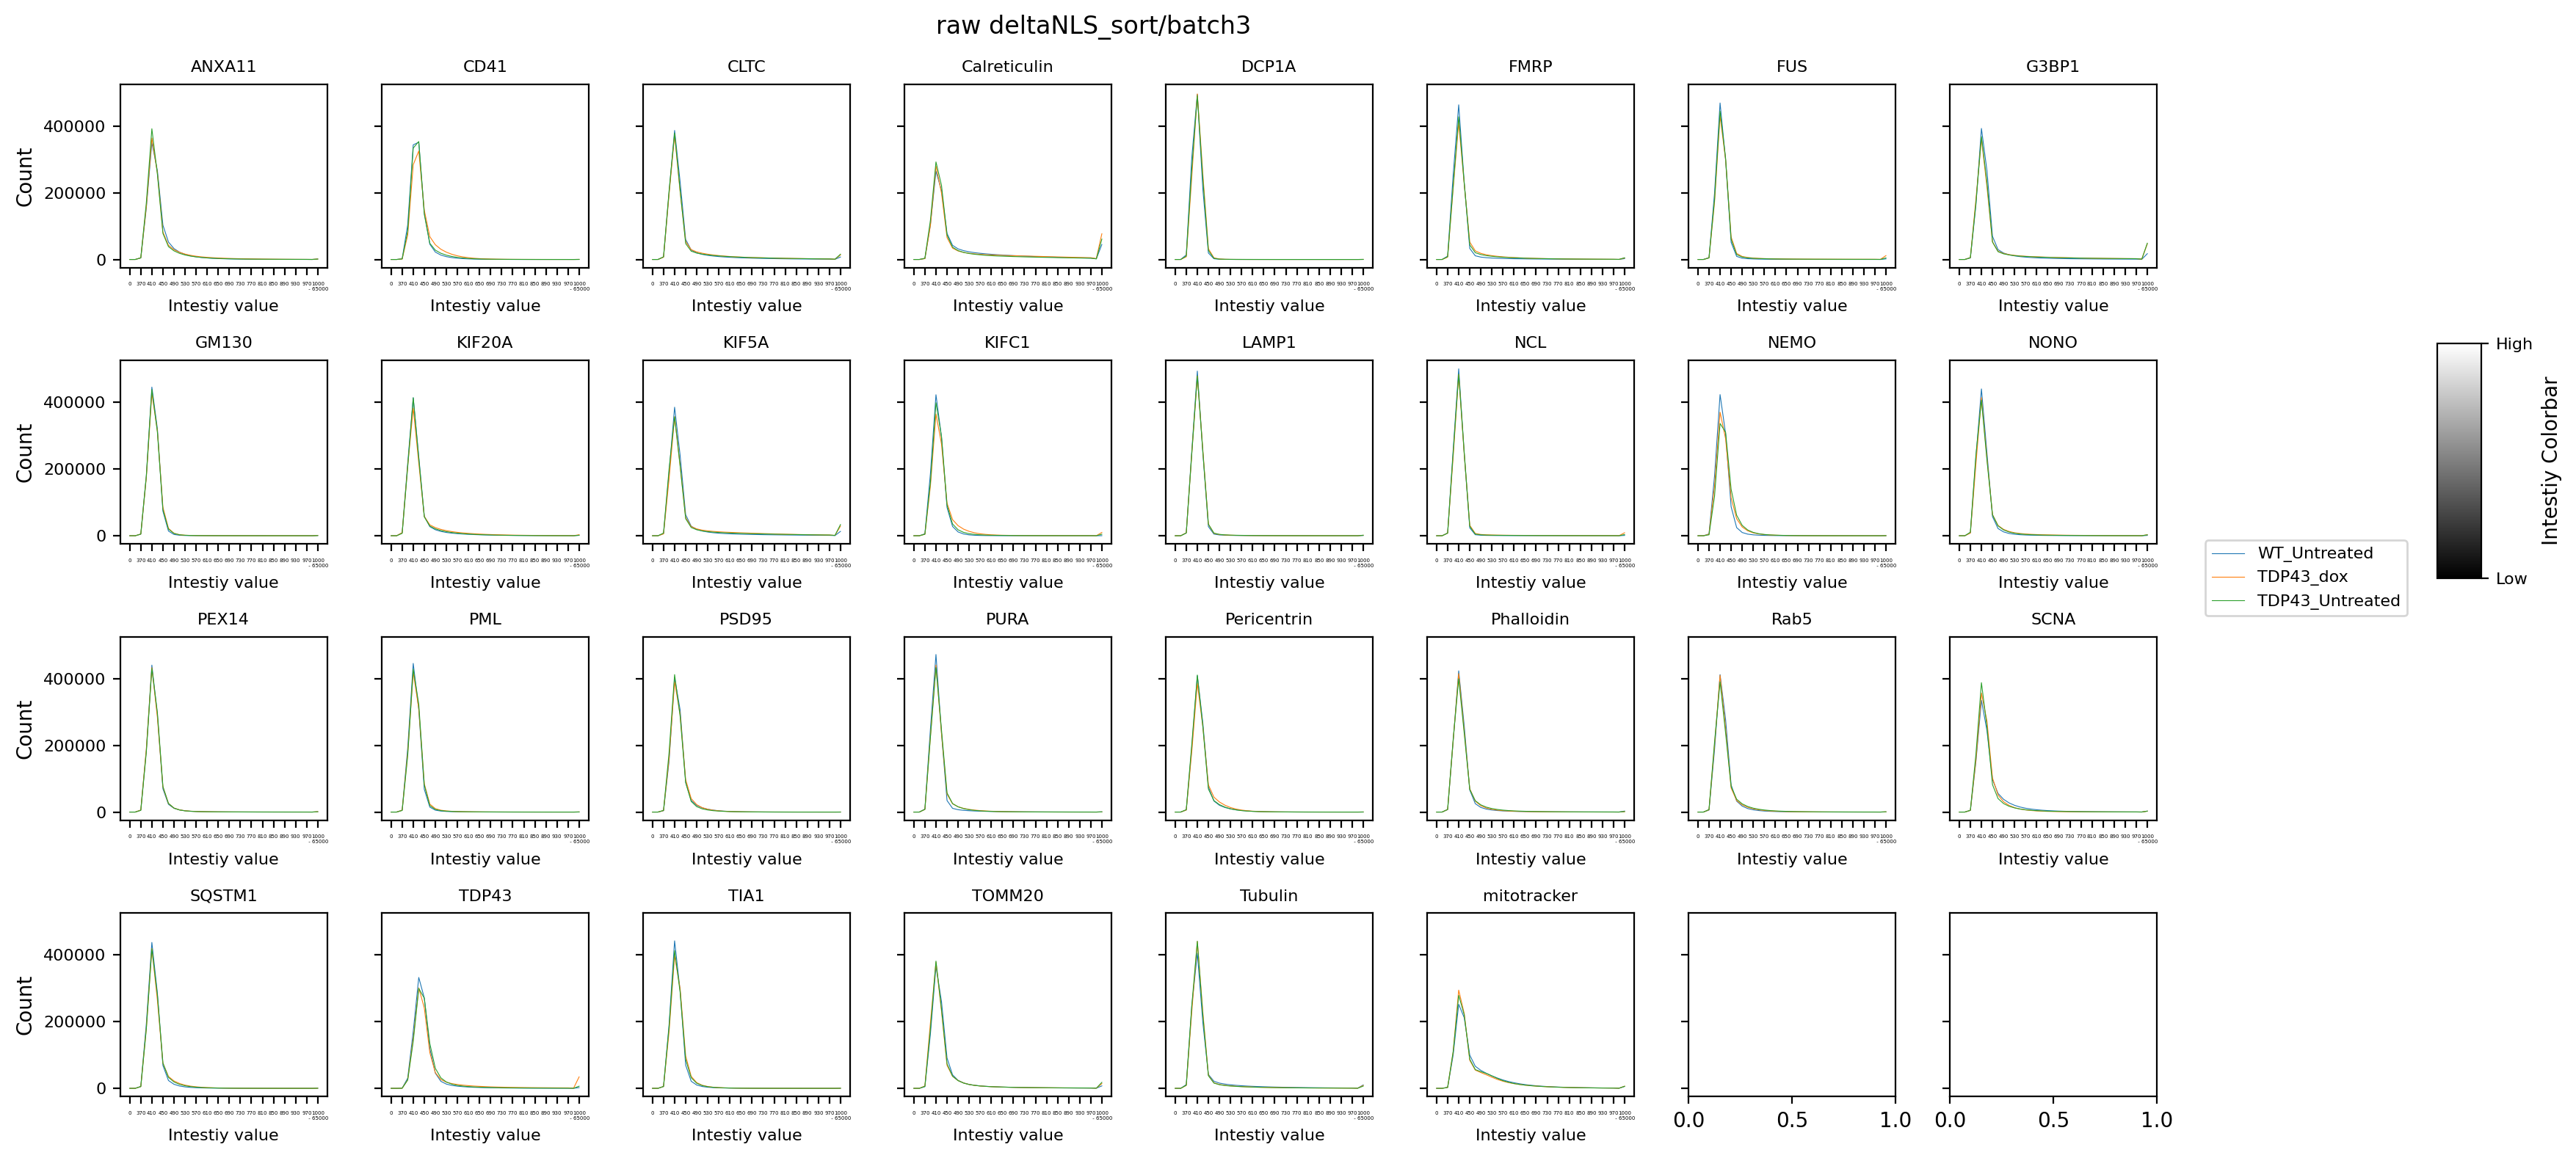

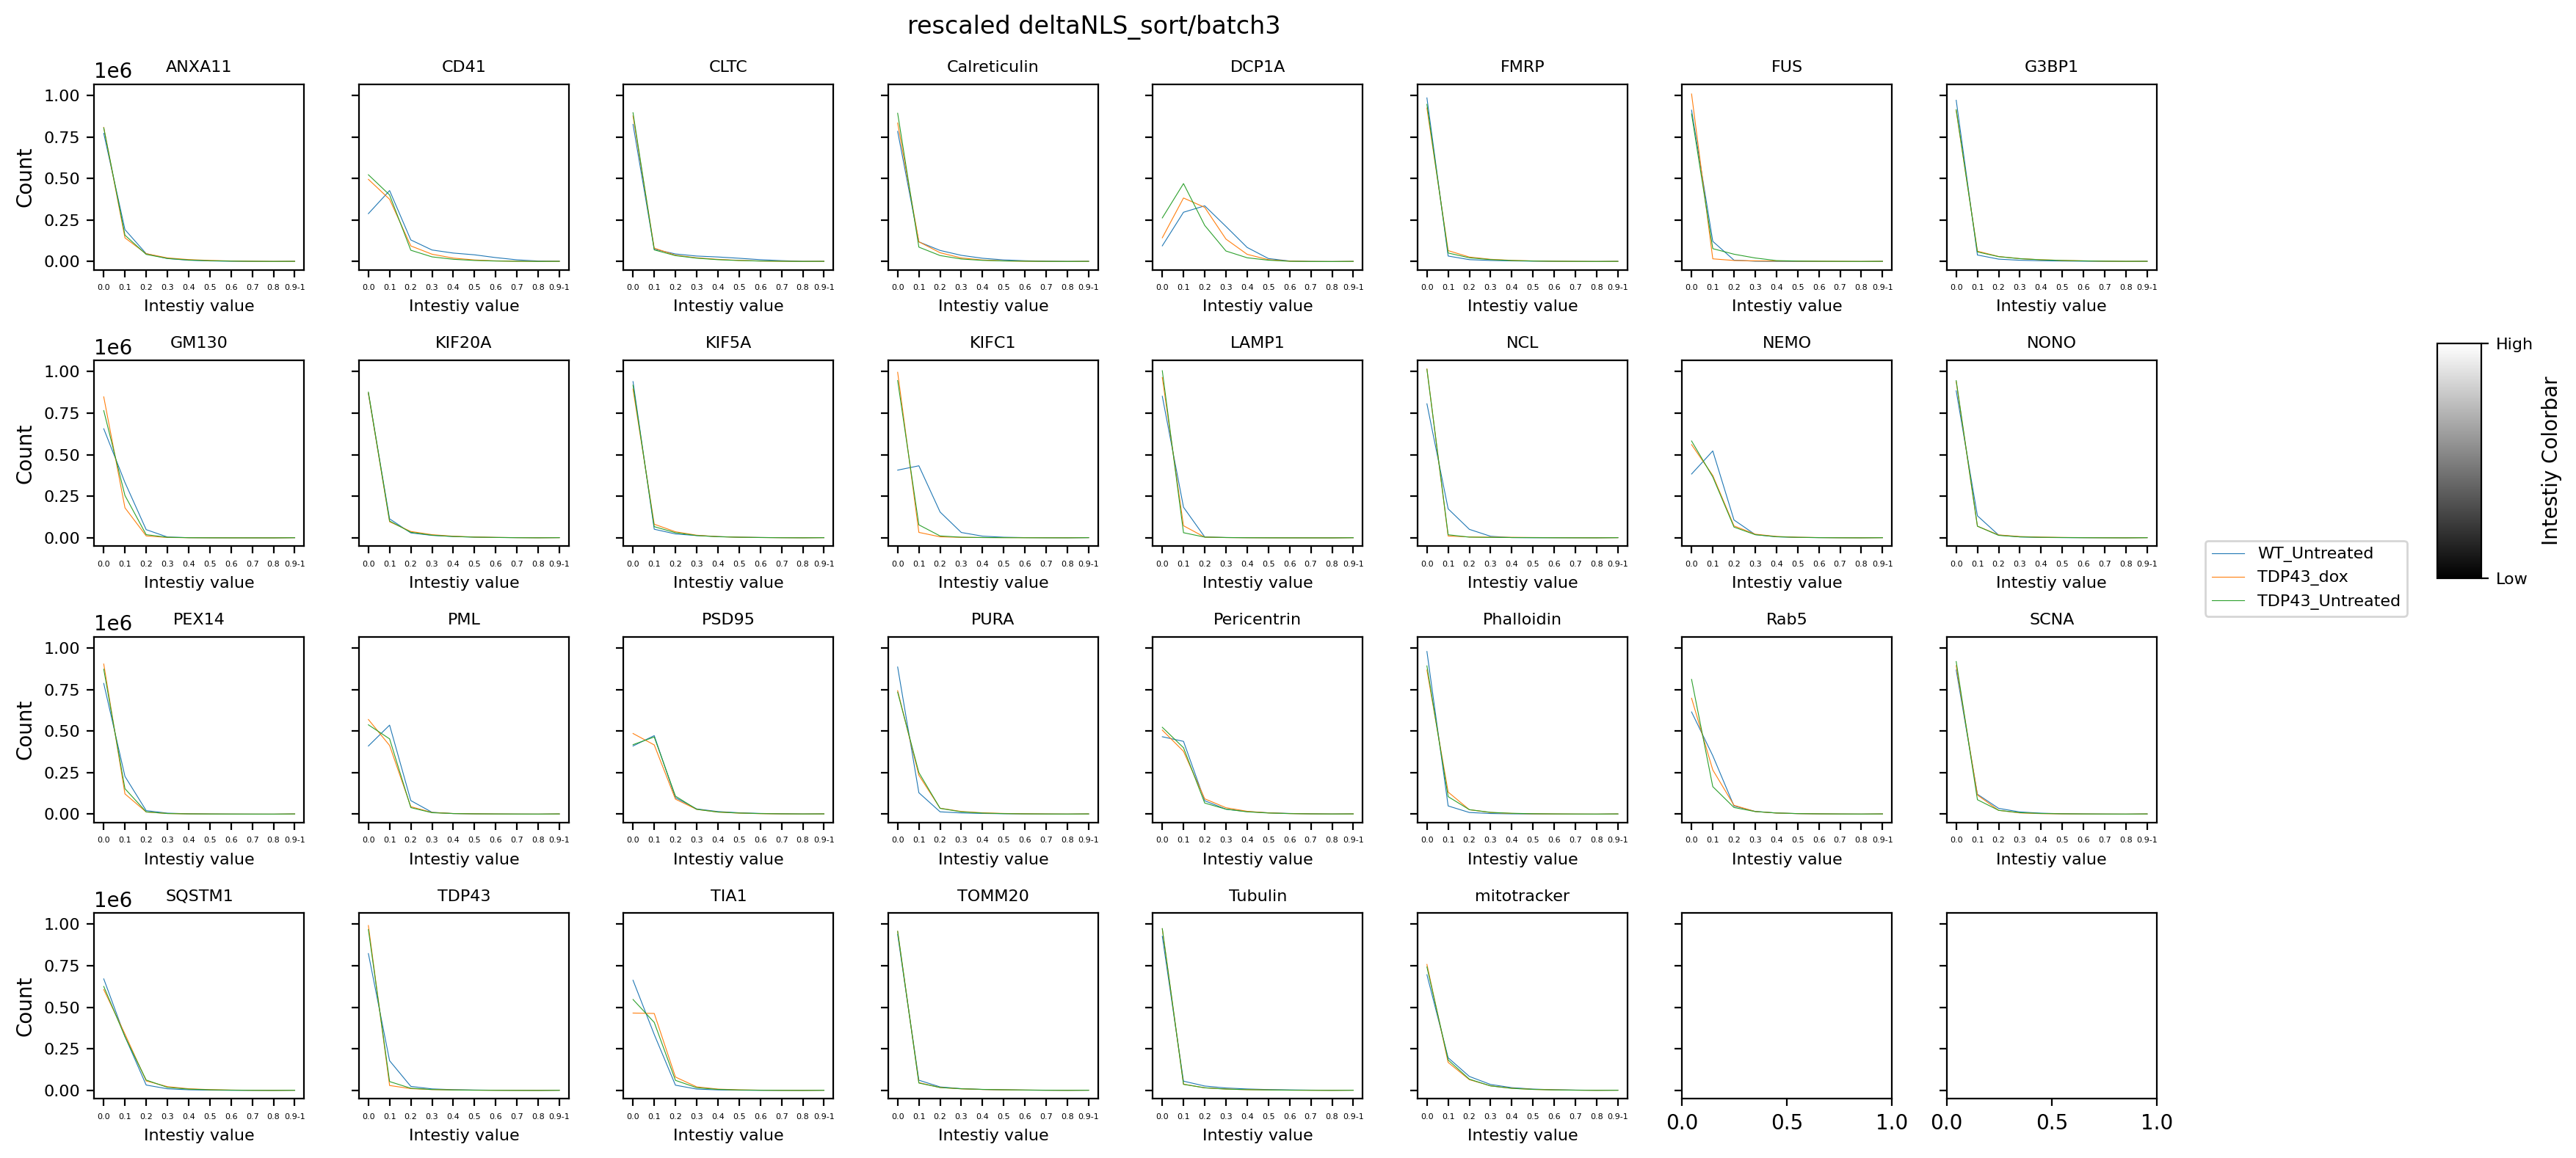

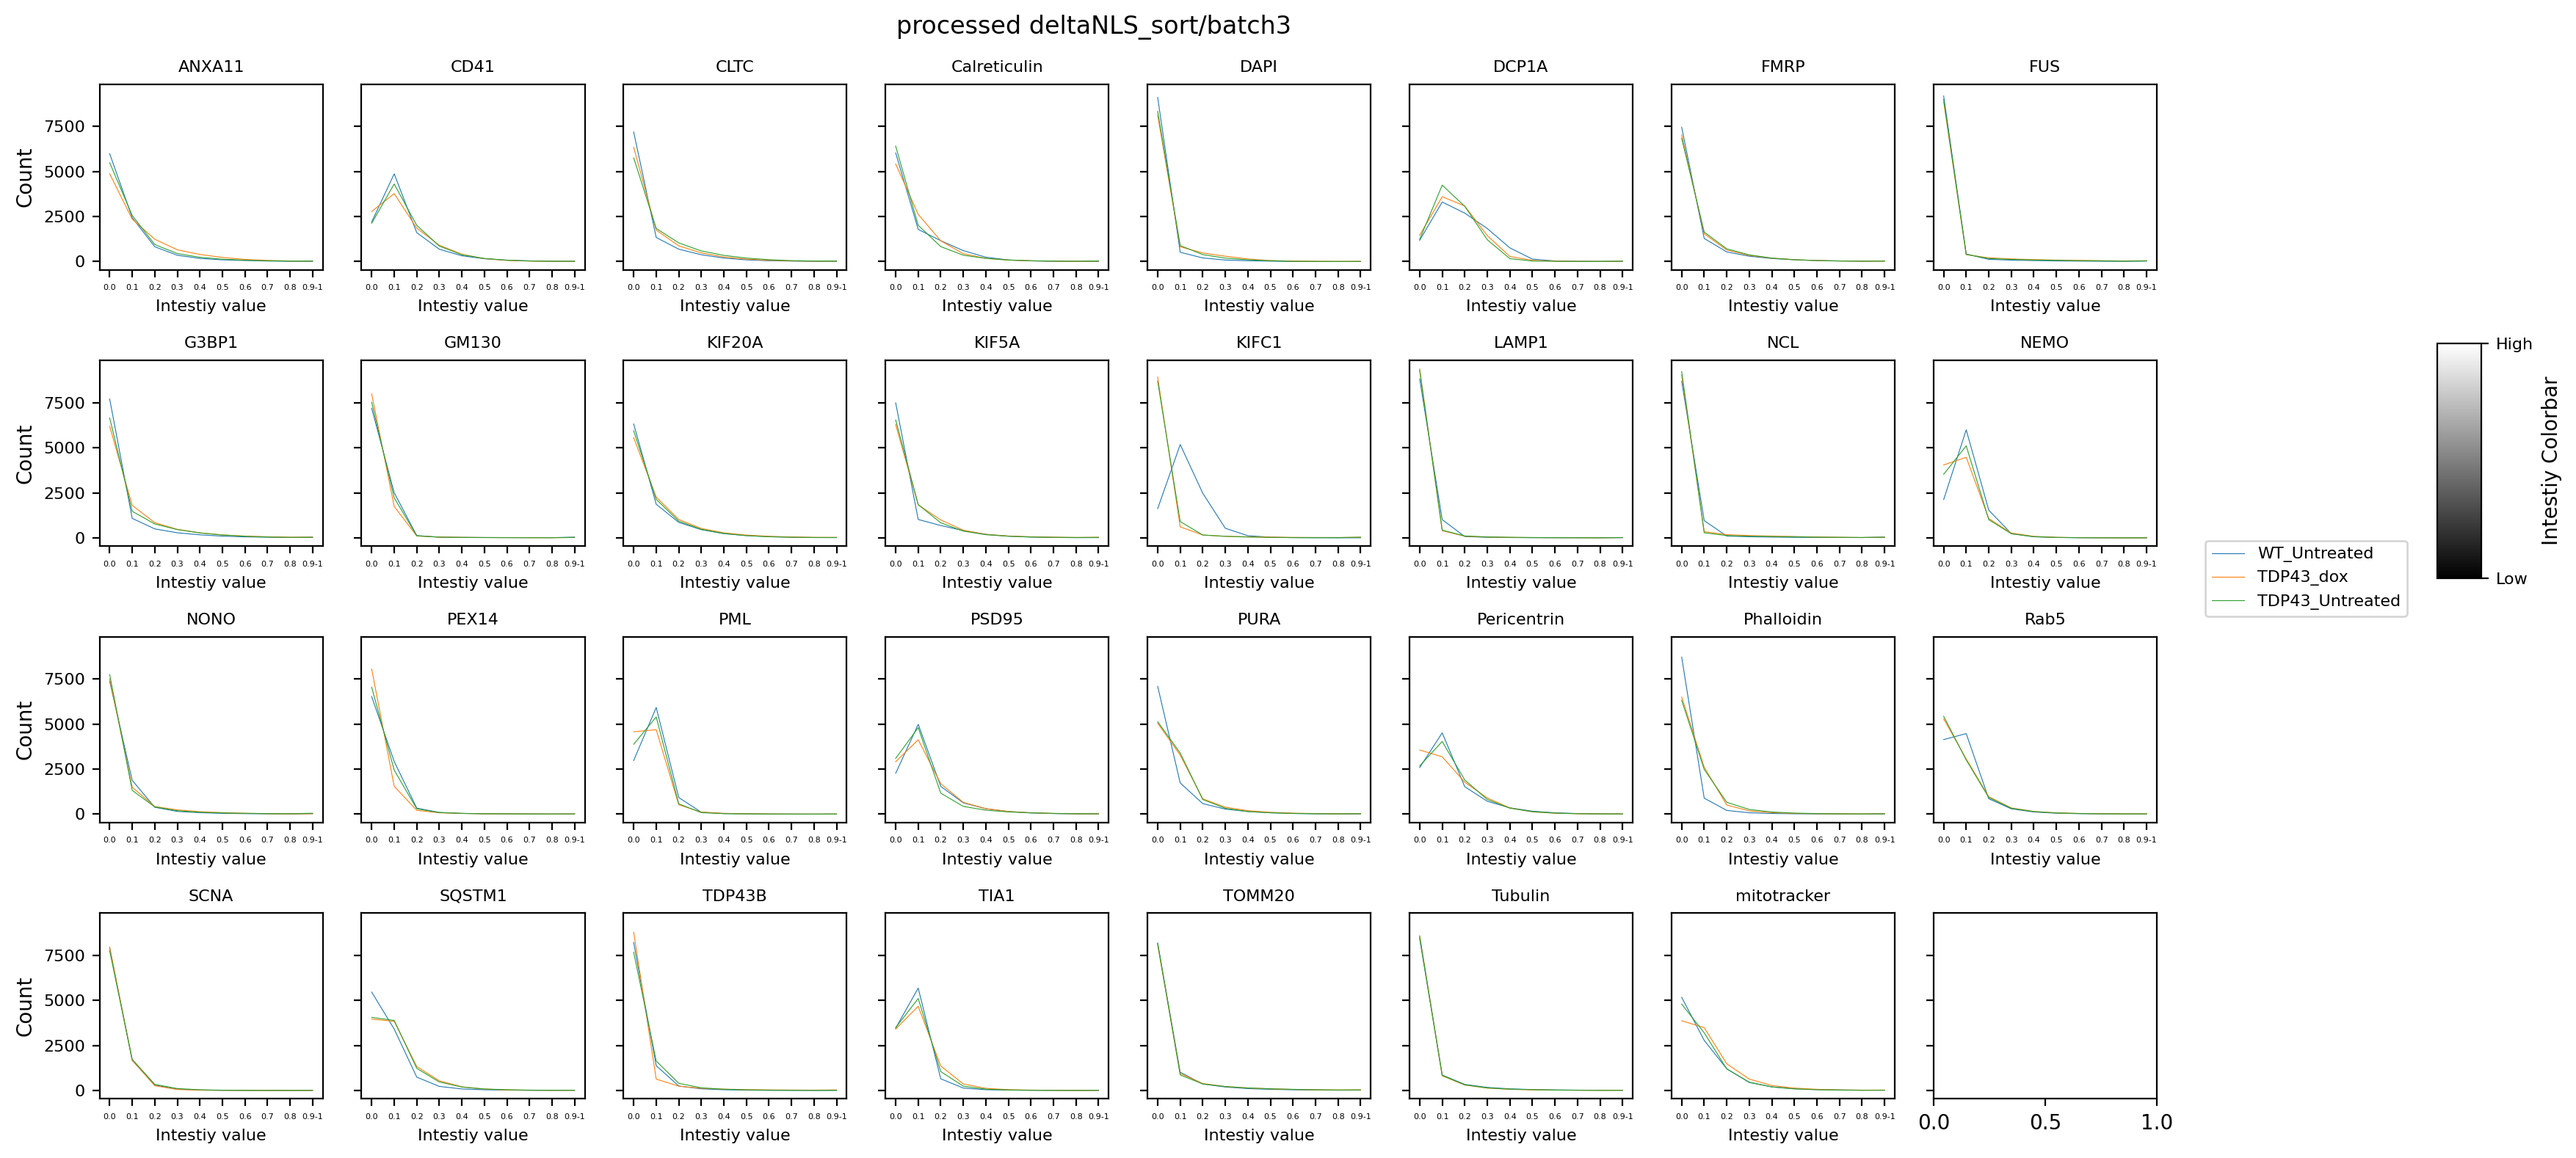

batch4


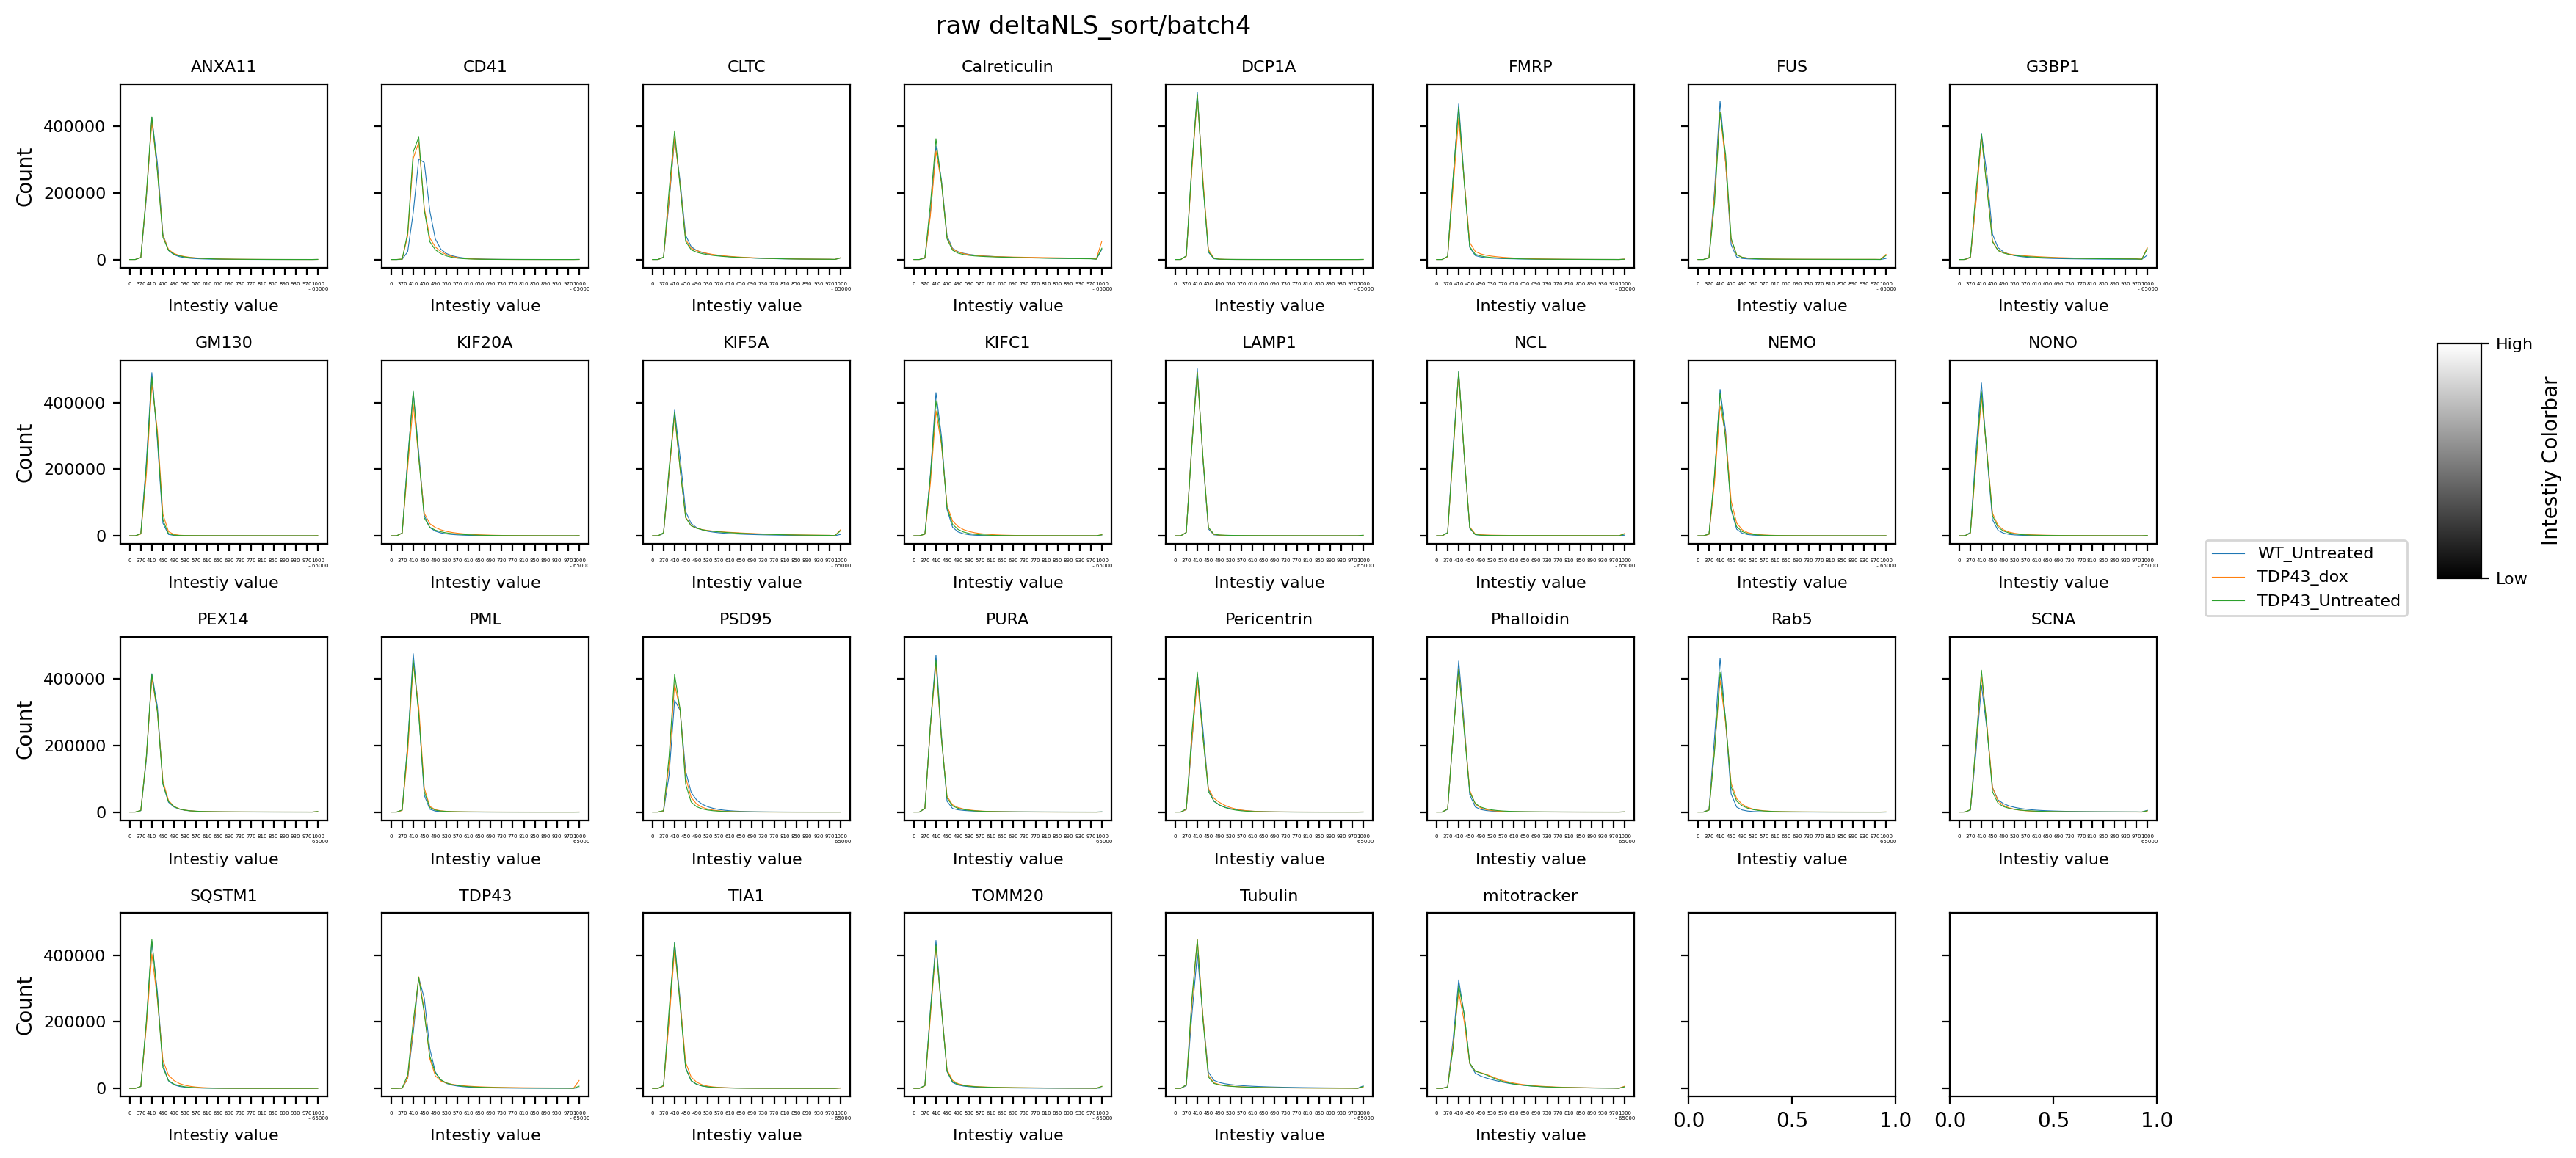

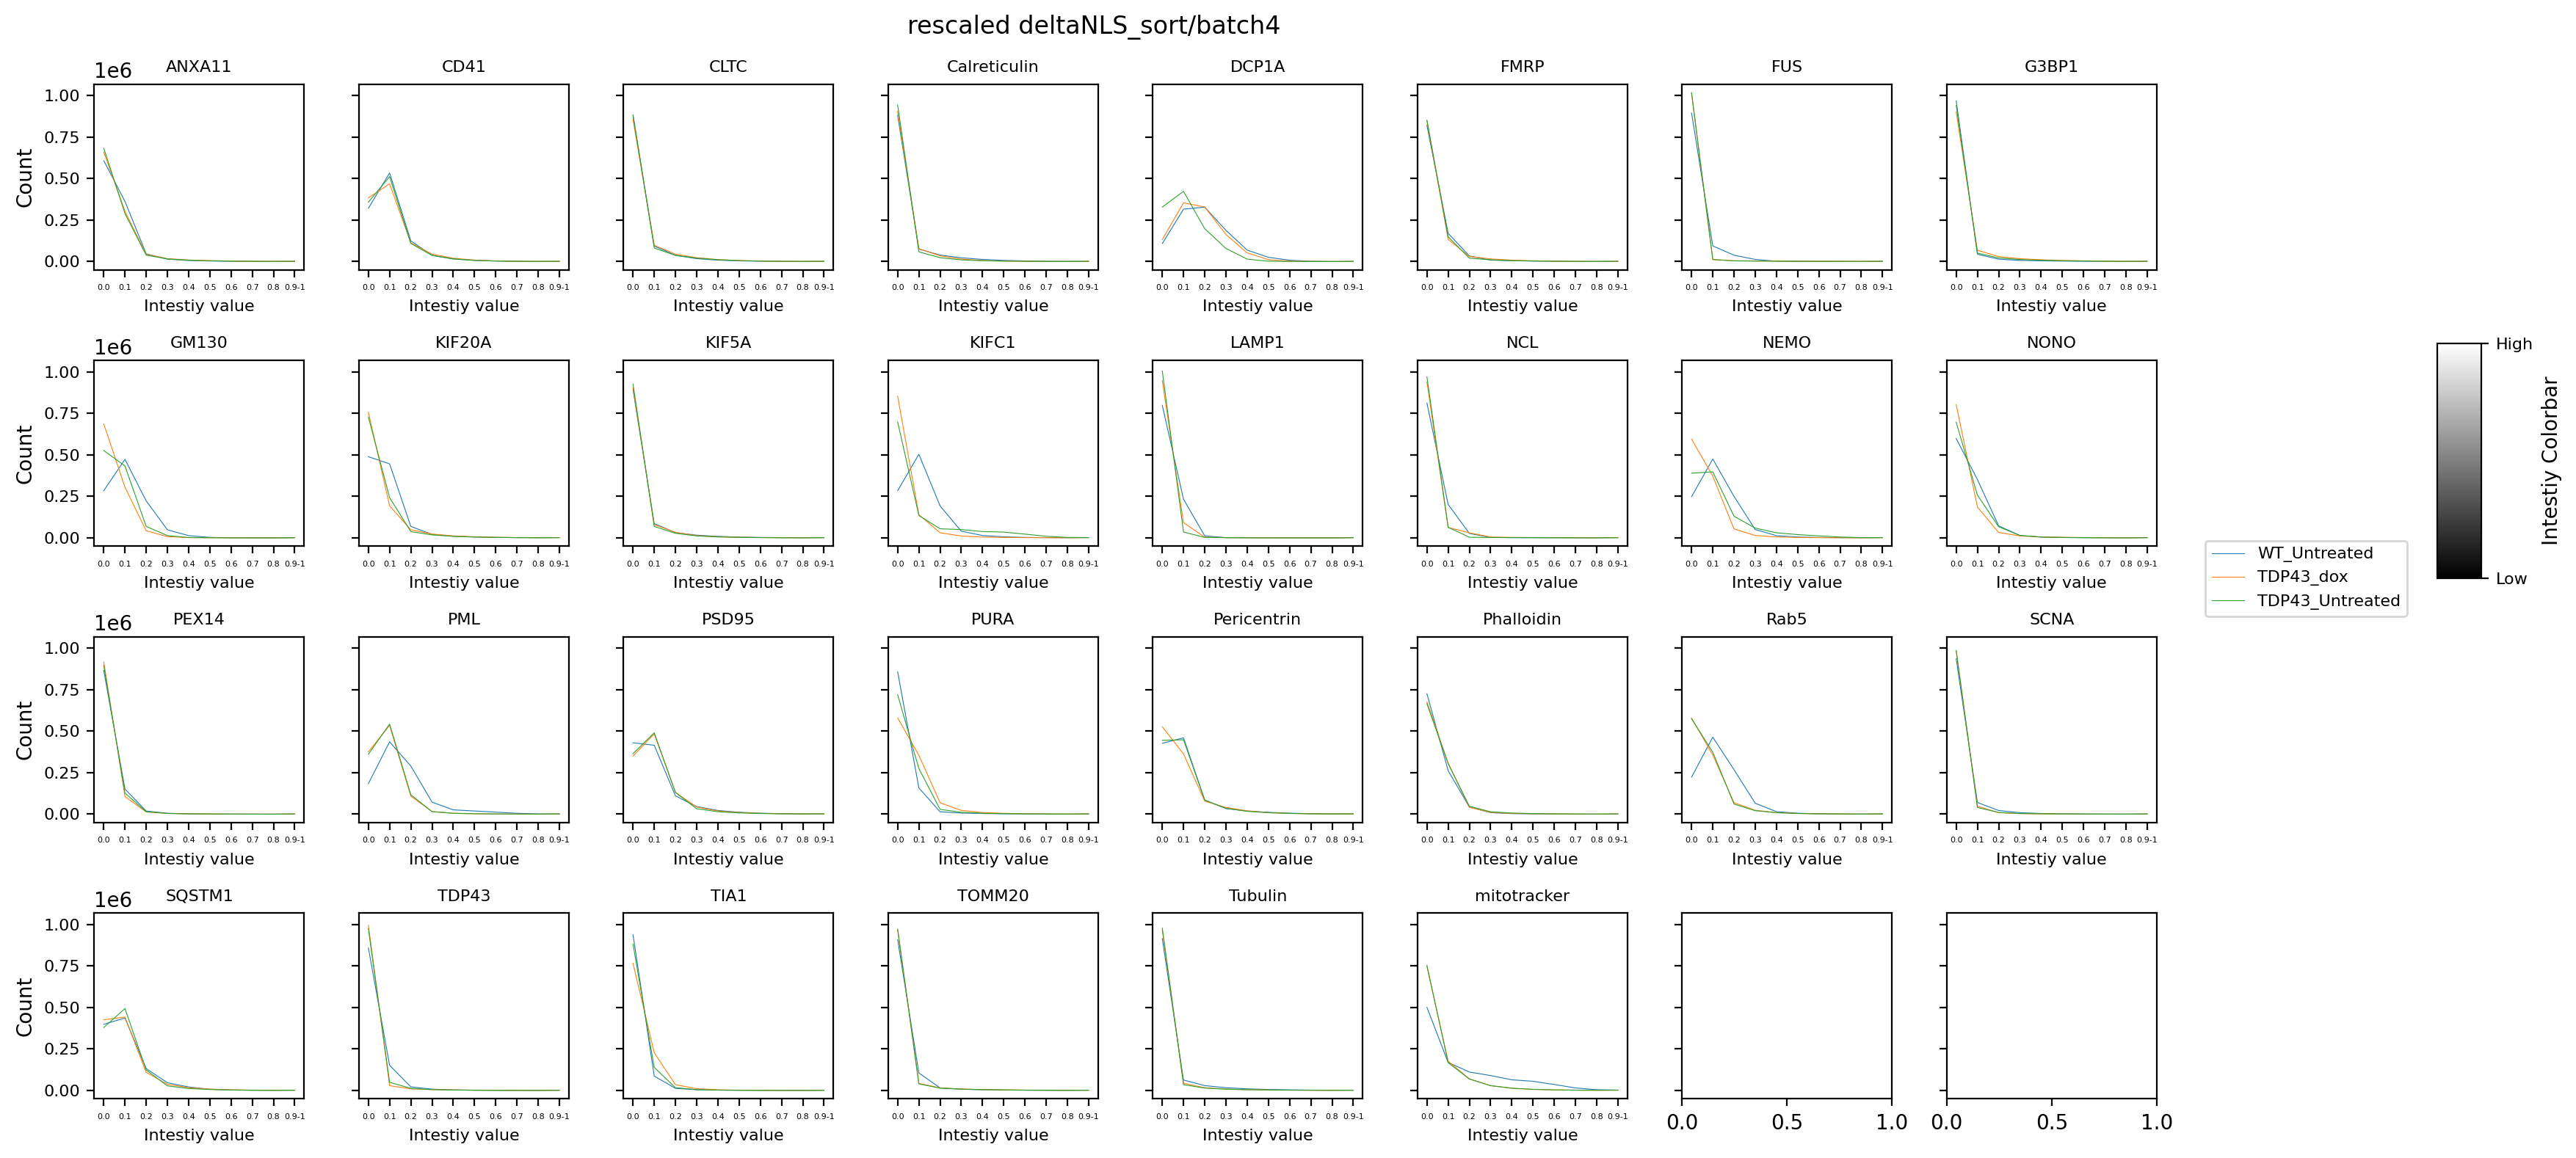

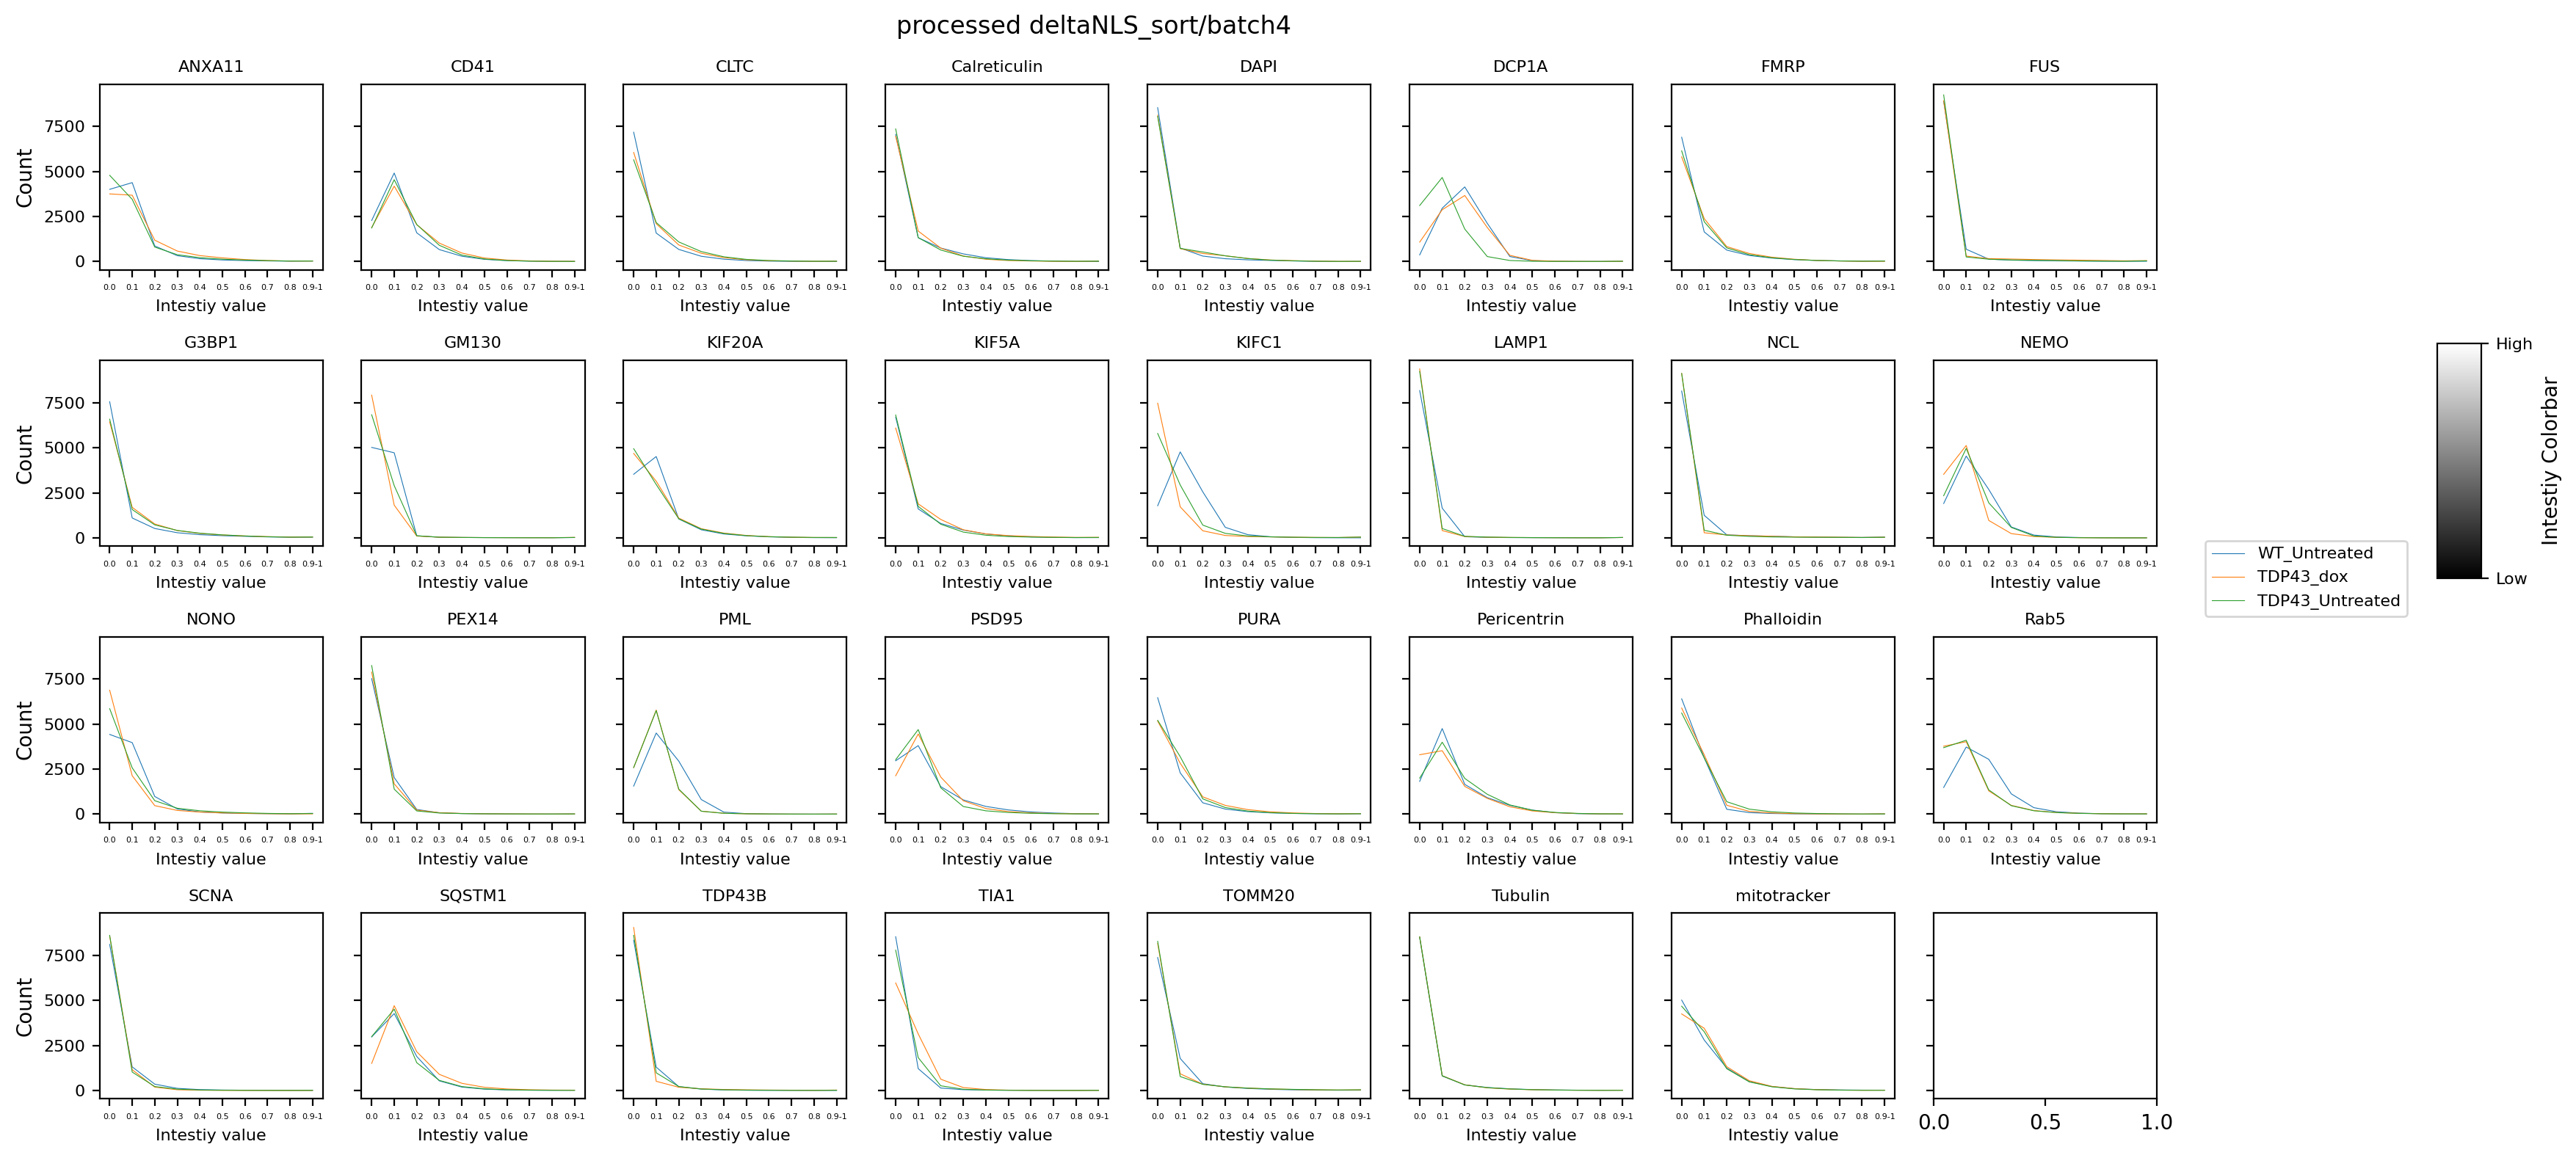

batch5


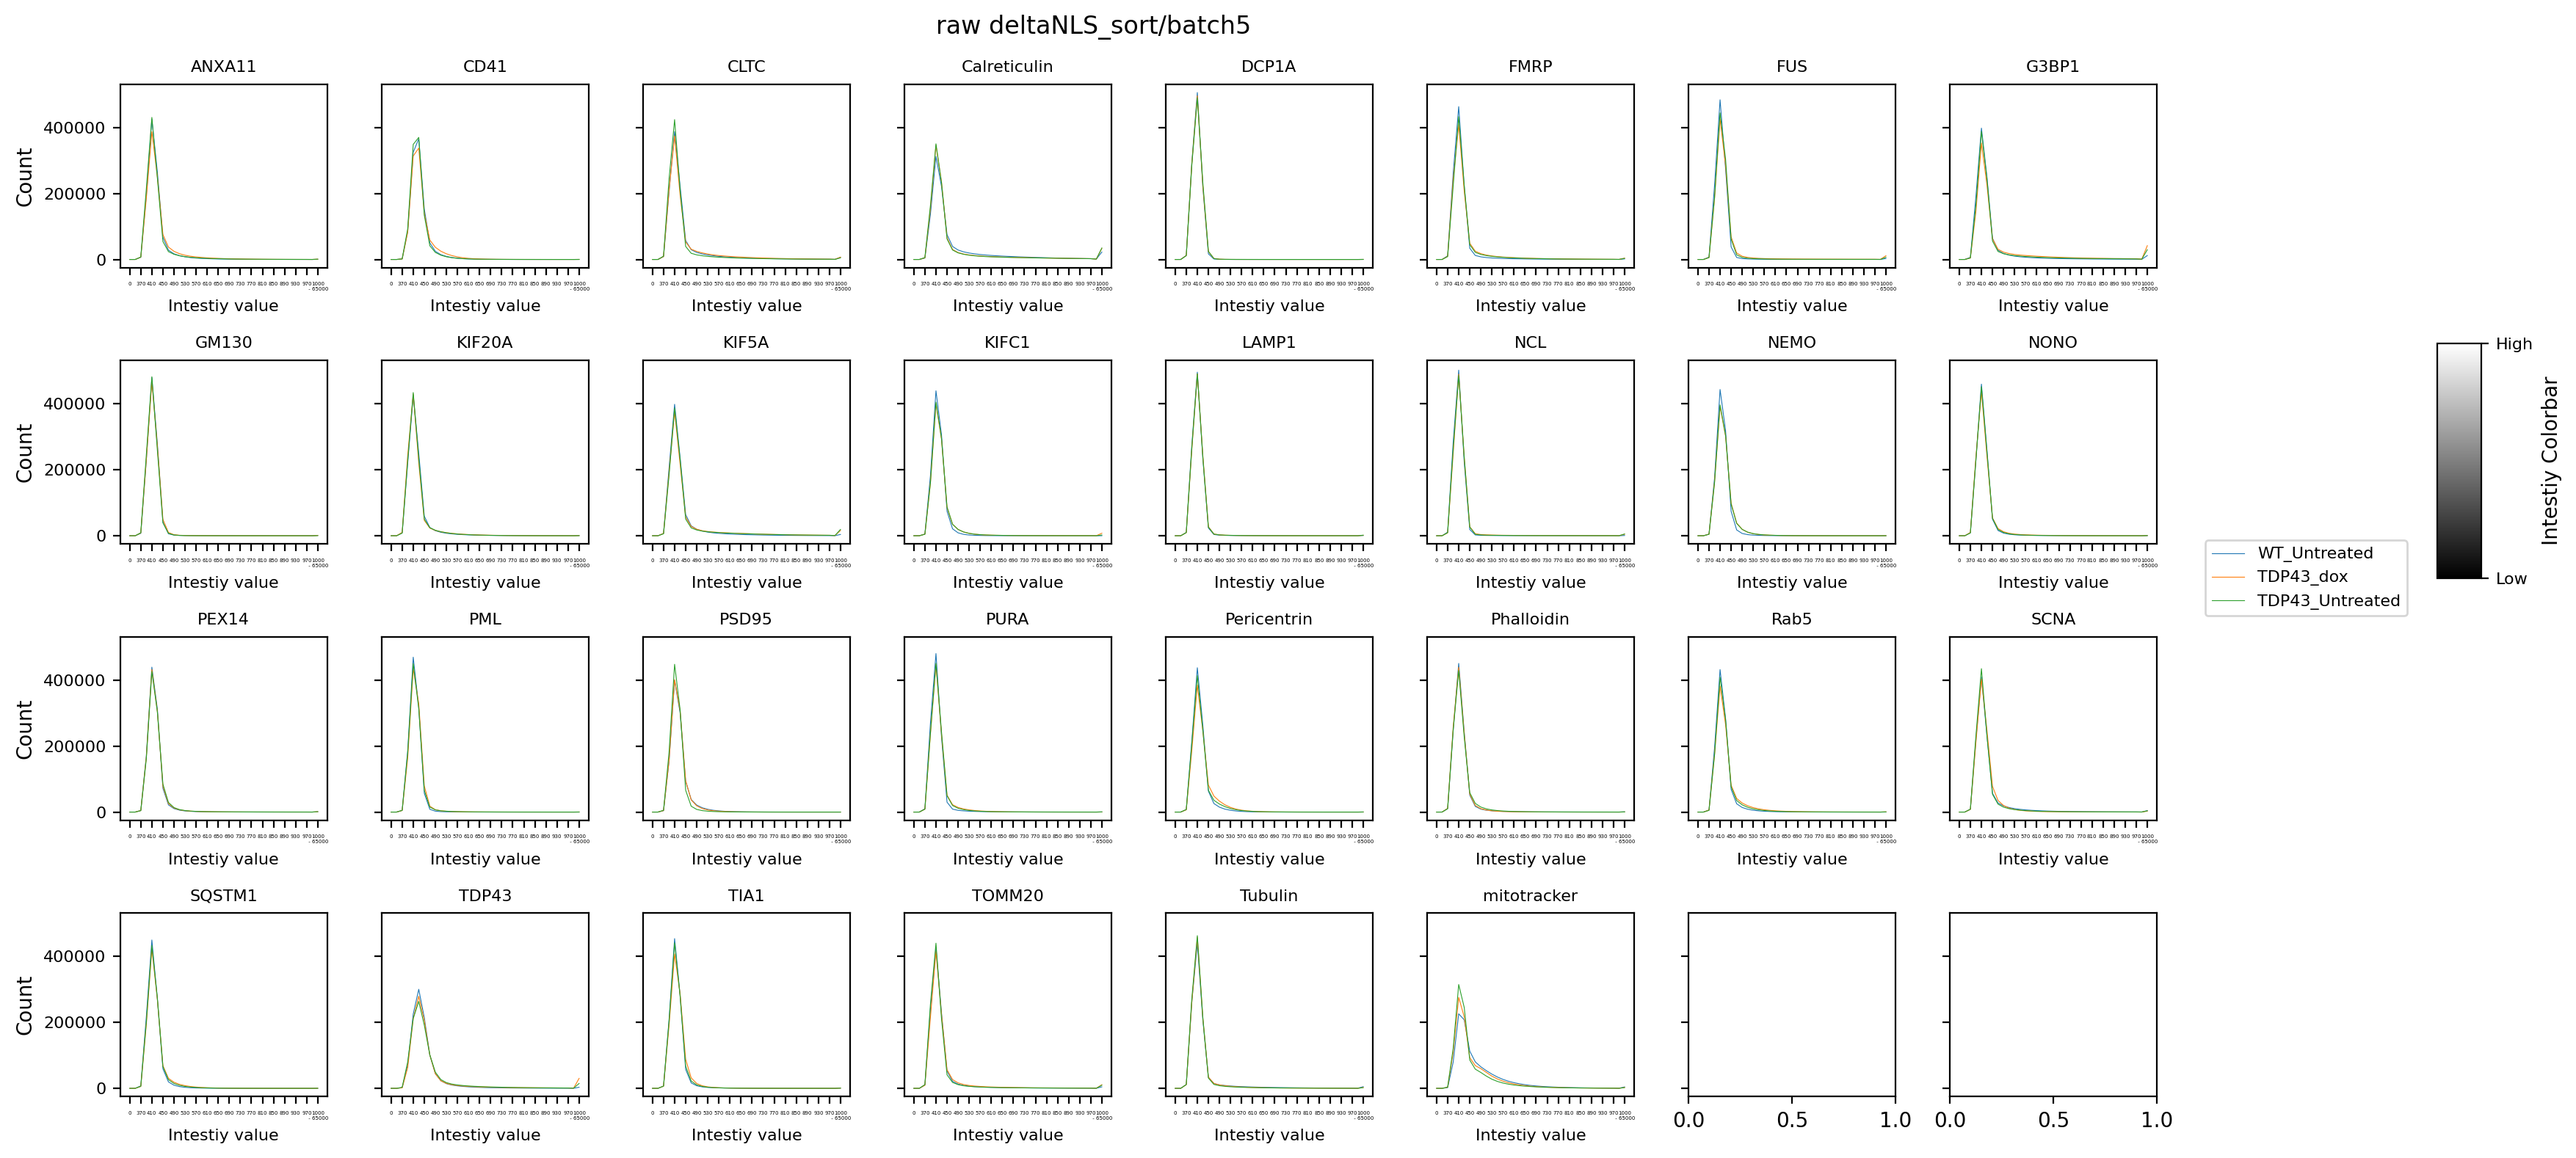

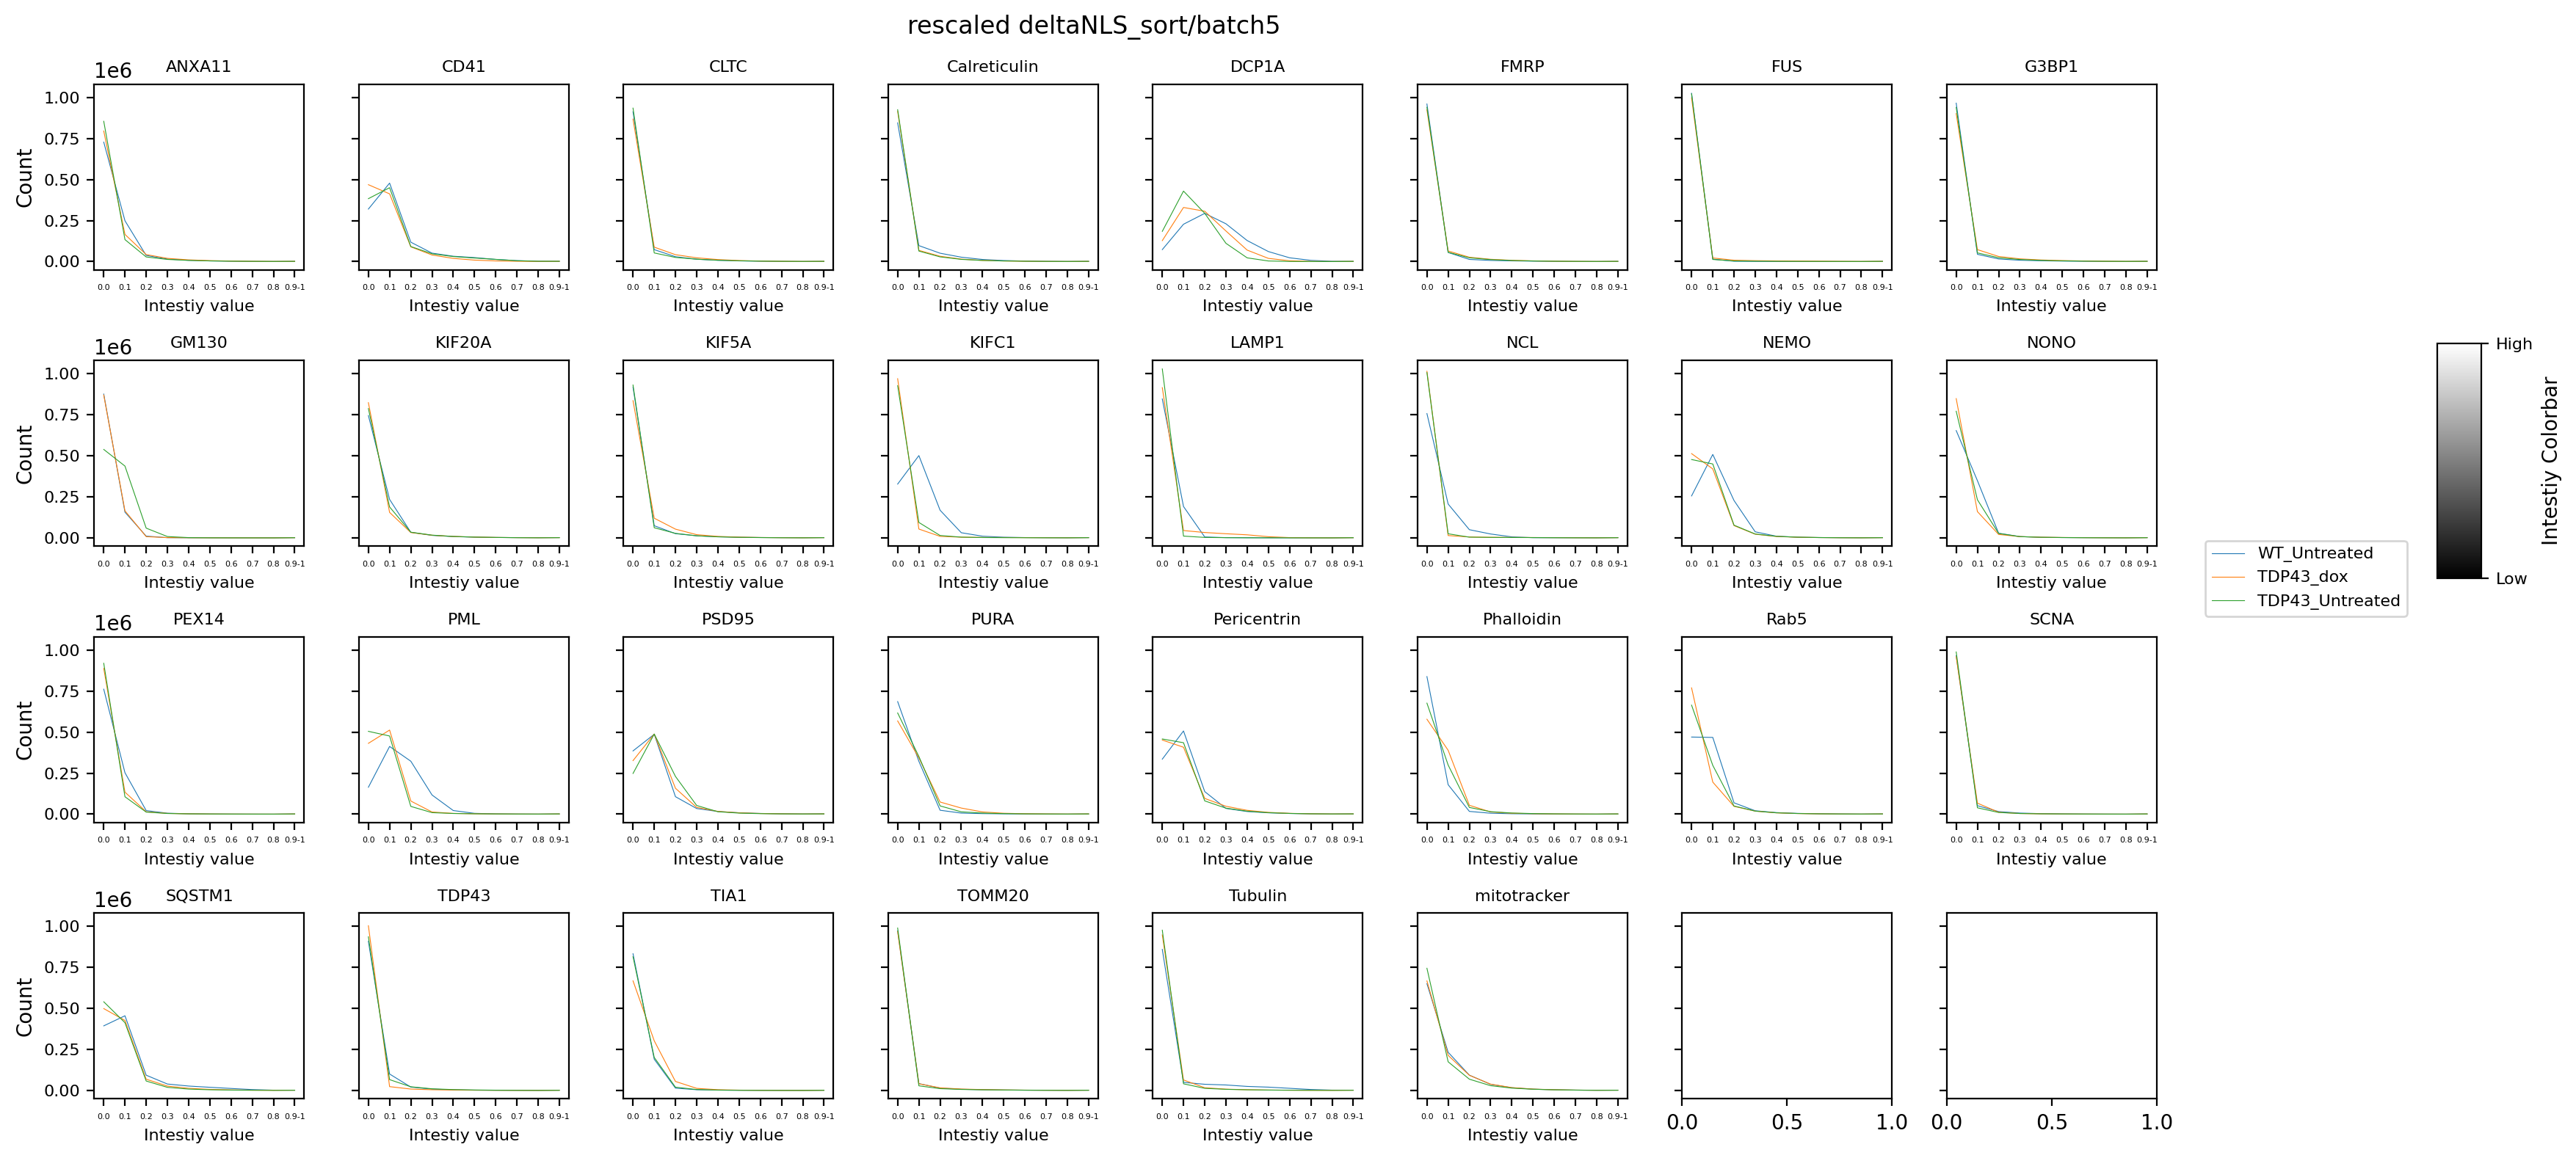

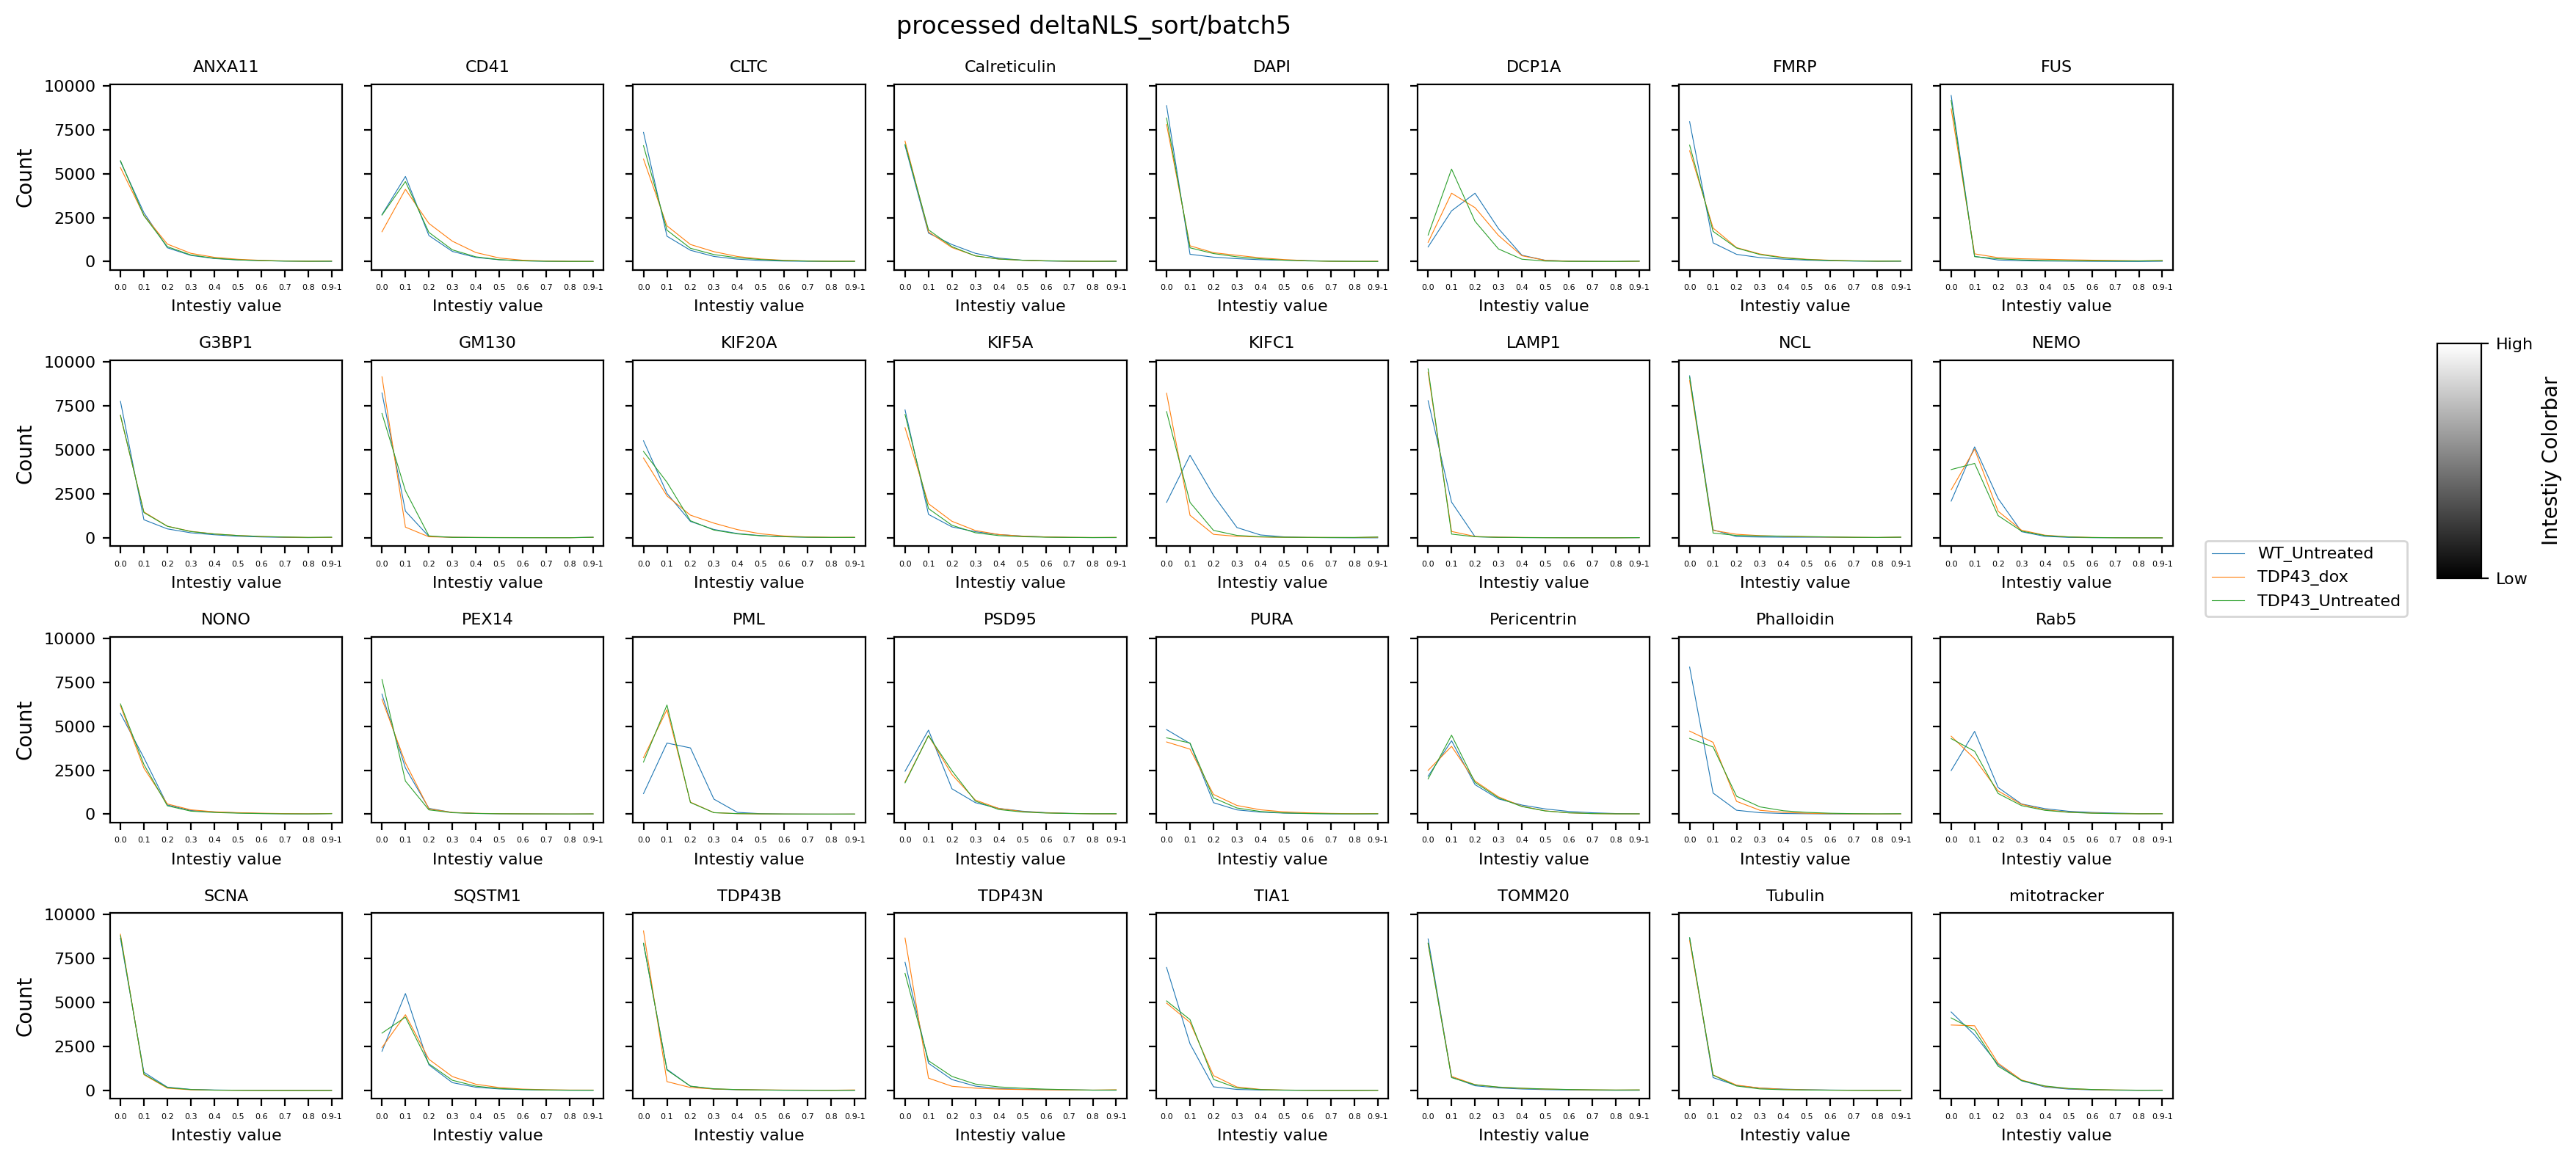

In [18]:
for batch in batches:
    print(batch)
    #batch_num = batch.replace('batch',"")
    run_calc_hist_new(f'deltaNLS_sort/{batch}', dnls_cell_lines_for_disp, dnls_markers, 
                           hist_sample=10,sample_size_per_markers=200, ncols=8, nrows=4, dnls=True)
    print("="*30)

In [3]:
# save notebook as HTML ( the HTML will be saved in the same folder the original script is)
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))
os.system('jupyter nbconvert --to html src/preprocessing/notebooks/no_ds/qc_report_newPP_dNLS.ipynb')

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook src/preprocessing/notebooks/no_ds/qc_report_newPP_dNLS.ipynb to html
[NbConvertApp] Writing 16681096 bytes to src/preprocessing/notebooks/no_ds/qc_report_newPP_dNLS.html


0